In [3]:
# Import
import pandas as pd
import pickle
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import bz2
import difflib
import logging
import time
import zlib
import itertools
import collections
import seaborn as sns
import glob
import os
import random
import re
import statsmodels.api as sm
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap
from itertools import chain, combinations, tee, islice, permutations
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from pathlib import Path
from collections import Counter 
from IPython.display import display
from os import path

-------------------------------
## Content
### A. For general use:
* [A1. Similarity measures](#A1.-Similarity-measures) 
    * [A1.1. Set-theoretic measures (Intersection, Overlap, Jaccard, SMC, LCS, ngram_abs)](#A1.1.-Set-theoretic-measures-(Intersection,-Overlap,-Jaccard,-SMC,-LCS,-ngram_abs)) 
    * [A1.2. ITR measures](#A1.2.-ITR-measures)
        * [A1.2.1. Here we first calculate the observed, expected and maximum items of a specific unit size](#A1.2.1.-Here-we-first-calculate-the-observed,-expected-and-maximum-items-of-a-specific-unit-size)
        * [A1.2.2. Then, we summarize them in final metrics (e.g., OmE (Pair Frequency/SOMA), OdE, OmEdM, OdM, OmEdMmE)](#A1.2.2.-Then,-we-summarize-them-in-final-metrics-(e.g.,-OmE-(Pair-Frequency/SOMA),-OdE,-OmEdM,-OdM,-OmEdMmE))
    * [A1.3. Edit distance measures](#A1.3.-Edit-distance-measures)
    * [A1.4. Graveyard for old similarity measure functions](#1.4.-Graveyard-for-old-similarity-measure-functions)

### B. Project specific: Data wrangling for experiments
* [B1. Experiment & Data overview](#B1.-Experiment-&-Data-overview)
* [B2. Pickle file conversion (old --> new)](#B2.-Pickle-file-conversion-(old--->-new))
* [B3. Data frame creation (incl. spell check); to be used for subsequent analysis](#B3.-Data-frame-creation-(incl.-spell-check);-to-be-used-for-subsequent-analysis)
* [B4. Similarity for dyads by sub-group](#B4.-Similarity-for-dyads-by-sub-group)
* [B5. Group means (Results presented in Manuscript)](#B5.-Group-means-(Results-presented-in-Manuscript))
* [B6. Correlation-Matrix (Results presented in Manuscript)](#B6.-Correlation-Matrix-(Results-presented-in-Manuscript))
-------------------------------

### __A1. Similarity measures__
#### A1.1. Set-theoretic measures (Intersection, Overlap, Jaccard, SMC, LCS, ngram_abs)

In [13]:
def intersection(str1, str2):
    intersection = len(np.intersect1d(str1, str2))
    return intersection

In [14]:
def overlap(str1, str2):
    intersection = len(np.intersect1d(str1, str2))

    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str1) >= len(str2):
        larger = len(str1) 
        smaller = len(str2)
    else:
        smaller = len(str1)
        larger = len(str2) 
    overlap = intersection / smaller
    return overlap

In [15]:
def Jaccard(str1, str2): 
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    union = len(np.union1d(str1, str2))
    intersection = len(np.intersect1d(str1, str2))

    Jaccard = intersection / union
    #print(Jaccard)
    return Jaccard

In [16]:
def SMC(str1, str2): # This counts the number of muturally forgotten items as "similar". TBD in case of Experiments 1B and 3
    encoding = list(range(1,85)) + [157,158,159,160] # Manual entry to get all words from the original study list             
    
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    intersection = len(np.intersect1d(str1, str2))
    
    Forgotten = 0
    for word in encoding:
        if word in str1 or word in str2:
            continue
        else:
            Forgotten += 1
    
    return (((Forgotten+intersection) / len(encoding)))

In [18]:
def ngram_abs(str1, str2, unitSize, y, unidirectional=True):
    
    """
    USAGE:
    #of bigrams/trigrams/ngrams = ngram_abs(str1, str2, unitSize, y, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Order/Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    Can be used to calculate the joint number of word pairs/bigrams or triplets/trigrams across two participants
    """
     
    #str1 = str1.values.tolist()
    #str2 = str2.values.tolist()
    string1 = None
    string2 = None
    
    if unidirectional == True:
        #return [np.array(x) for x in zip(string[0:-1], string[1:])]
        iters = tee(str1, unitSize)                                                     
        for i, it in enumerate(iters):                                               
            next(islice(it, i, i), None)
            
        iters2 = tee(str2, unitSize)                                                     
        for i, it in enumerate(iters2):                                               
            next(islice(it, i, i), None)
           
        string1 = list(zip(*iters))
        string2 = list(zip(*iters2))
    else:
        s = list(str1)
        powerset = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
        s2 = list(str2)
        powerset2 = chain.from_iterable(combinations(s2, r) for r in range(len(s2)+1))
        string1 = [(x) for x in powerset if len(x)==unitSize]
        string2 = [(x) for x in powerset2 if len(x)==unitSize]
    #print(string1)
    #print(string2)

    # This is for assining unique numbers to the different n-grams. At the moment it is executed elsewhere,\ 
    # but one could also execute it in here
    #y = permu(unitSize)
    #all_p = pd.DataFrame()
    #all_p['AllPermutations'] = y
    
    a_list = []
    for i in (string1):
        if i in y:
            x = y.index(i)
        else:
            continue
        a_list.append(x)

    b_list = []
    for i in (string2):
        if i in y:
            x = y.index(i)
        else:
            continue
        b_list.append(x)
    
    count = 0
    for i in string1:
        if i in string1 and i in string2:
            count += 1
        else:
            count += 0
    #print(count)
    #a = np.array(a_list)
    #b = np.array(b_list)
    
    return count

In [17]:
# Adapted from source: https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Longest_common_substring#Python
def lcs(str1, str2):
    m = [[0] * (1 + len(str2)) for i in range(1 + len(str1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(str1)):
        for y in range(1, 1 + len(str2)):
            if str1[x - 1] == str2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    string = (str1[x_longest - longest: x_longest])
    lcs = len(string)
    #print(string)
    return lcs

In [19]:
# ATTENTION! This needs to be manually adjusted over the experiments to identify the max of permutations, which is specific to the experiment
def permu(n):
    df_max = pd.read_csv('2020-08-14_Similarity_Availability_AllWords_Clean.csv')
    maxi = max(df_max.number) 
    #print(maxi)
    all = list(range(0,maxi))
    y = list(itertools.permutations(all, n))
    return y

#### __A1.2. ITR measures__

##### A1.2.1. Here we first calculate the observed, expected and maximum items of a specific unit size

In [20]:
def observed(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = observed(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the observed words of a specific unit size to be used in subsequent shared organization measures
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str1) == 0:
        return []
    elif len(str2) ==0:
        return []
            
    ob_freq = 0
    for i in range(len(str1)-1):
        p1 = str1[i]
        p2 = str1[i+1]
        if unitSize ==3:
            p3 = str1[i+2]
        elif unitSize ==4:
            p3 = str1[i+2]
            p4 = str1[i+3]

        if unitSize == 2:
            if p1 in str2 and p2 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i2[0] - i1[0]) == 1:
                        ob_freq += 1
                else:
                    if abs(i2[0] - i1[0]) == 1:
                        ob_freq += 1                
            
        elif unitSize == 3:
            if p1 in str2 and p2 in str2 and p3 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                i3 = np.nonzero(np.array(str2) == p3)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i2[0] - i1[0]) == 1 and (i3[0] - i1[0]) == 2 and (i3[0] - i2[0]) == 1:
                        ob_freq += 1
                else:
                    if abs(i2[0] - i1[0]) <= 2 and abs(i3[0] - i2[0]) <= 2 and abs(i3[0] - i1[0]) <= 2: # I think I might not need the last and
                        ob_freq += 1  
            
        elif unitSize == 4:
            if p1 in str2 and p2 in str2 and p3 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                i3 = np.nonzero(np.array(str2) == p3)
                i4 = np.nonzero(np.array(str2) == p4)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i4[0] - i1[0]) == 3 and (i3[0] - i1[0]) == 2 and (i2[0] - i1[0]) == 1 and \
                    (i4[0] - i2[0]) == 2 and (i4[0] - i3[0] == 1) and (i3[0]-i2[0] == 1):
                        ob_freq += 1
                else:
                    if \
                    abs(i2[0] - i1[0]) <= 3 and abs(i3[0] - i1[0]) <= 3 and abs(i4[0] - i1[0]) <= 3 and \
                    abs(i3[0] - i2[0]) <= 3 and abs(i4[0] - i2[0]) <= 3 and \
                    abs(i4[0] - i3[0]) <= 3: 
                        ob_freq += 1     
           
    return ob_freq

In [21]:
def expected_BB(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = expected_BB(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.) --> Is always 2 in this case
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the expected organization of word pairs to be used in subsequent shared organization measures
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    # This is only for pairs   
    if unitSize != 2:
        return "Use different expected calculation for higher order unit sizes"
    
    # Calc expected
    num_common_items = len(np.intersect1d(str1, str2))
    if unidirectional == True:
        x = 1
    else:
        x = 2
        
    exp_freq = (x*num_common_items*(num_common_items-1)) / float(len(str1)*len(str2))

    if num_common_items == 0:
        return 0
    else:
        return exp_freq

In [22]:
def expected_generalized(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = expected_BB(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the expected organization of word pairs to be used in subsequent shared organization measures: ((N-X-1)! * A * (M-X + 1-R)) / N!
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    
    # Calculate expected value according to Boulsfield & Boulsfield
    num_common_items = len(np.intersect1d(str1, str2))
    if unidirectional == True:
        x = 1
    else:
        x = 2
    exp_freq = (x*num_common_items*(num_common_items-1)) / float(len(str1)*len(str2))
    #print('x', x)
    
    return exp_freq

In [23]:
def maximum(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = maximum(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the maximum possible organization of word pairs to be used in subsequent shared organization measures: (c - x + 1)
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    num_common_items = len(np.intersect1d(str1, str2))

    if num_common_items == 0:
        return 0
    elif num_common_items == 1:
        return 0
    else:
        return (num_common_items - unitSize + 1)

##### A1.2.2. Then, we summarize them in final metrics (e.g., OmE (Pair Frequency/SOMA), OdE, OmEdM, OdM, OmEdMmE)

In [24]:
def OmE(str1, str2, unitSize, unidirectional=True):   
    """
    DESCRIPTION:
    Unidirectional & pair = ITR (Bousfield & Bousfield (1966))
    Bidirectional & pari = Pair(ed) Frequency (Anderson & Watts (1969); Rosner (1970))
    """
    
    if unidirectional==True:
        return observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)
    else:
        return observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)

In [25]:
def OdE(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Referred to as Sequential Consistency by Sternberg & Tulving (1977), developed by Gorfein, Blair, & Rowland (1968)
    """
        
    if expected_BB(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return observed(str1, str2, unitSize, unidirectional=True) / expected_BB(str1, str2, unitSize, unidirectional=True)
        else:
            return observed(str1, str2, unitSize, unidirectional=False) / expected_BB(str1, str2, unitSize, unidirectional=False)


In [26]:
def OmEdM(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Referred to as Sequential Consistency by Sternberg & Tulving (1977)
    Unidirectional pairs, Fagan (1968)
    Bidirectional pairs, Postman (1970)
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return ((observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)) / maximum(str1, str2, unitSize, unidirectional=True))
        else:
            return ((observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)) / maximum(str1, str2, unitSize, unidirectional=False))

In [27]:
def OdM(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    For bidirectional pairs referred to as ITR(2) (Mandler & Dean (1969))
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return (observed(str1, str2, unitSize, unidirectional=True) / maximum(str1, str2, unitSize, unidirectional=True))
        else:
            return (observed(str1, str2, unitSize, unidirectional=False) / maximum(str1, str2, unitSize, unidirectional=False))

In [28]:
def OmEdMmE(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Generally referred to as ARC' (Pellegrino (1971); Pellegrino & Battig (1974))
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0 and expected_BB(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return ((observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)) / (maximum(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)))
        else:
            return ((observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)) / (maximum(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)))

### __A1.3. Edit distance measures__

In [36]:
def edit_dists(string1, string2, insert=True, delete=True, substitute=True, transpose=True):

    if len(string1) > len(string2):
        string1, string2 = string2, string1

    n1 = len(string1)
    n2 = len(string2)
    d = np.zeros((n1 + 1, n2 + 1), dtype=int)

    for i in range(n1 + 1):
        d[i, 0] = i

    for j in range(n2 + 1):
        d[0, j] = j

    for i in range(n1):
        for j in range(n2):
            options = []
            # insertion
            if insert:
                options += [d[i, j+1] + 1]
            # deletion
            if delete:
                options += [d[i+1, j] + 1]
            # substitution
            if substitute and not(string1[i] == string2[j]):
                options += [d[i, j] + 1]
            # identical entries are free
            elif string1[i] == string2[j]:
                options += [d[i, j] + 0]

            d[i+1, j+1] = min(options)
            #d[i+1, j+1] = min(d[i, j+1] + 1, # insert
            #                  d[i+1, j] + 1, # delete
            #                  d[i, j] + cost) # replace

            if transpose:
                if i > 0 and j > 0 and string1[i] == string2[j-1] and string1[i-1] == string2[j]:
                    d[i+1, j+1] = min(d[i+1, j+1], d[i-1, j-1] + int(not(string1[i] == string2[j]))) # transpose


    # if substitution, max # of edits is max(n1, n2)

    if substitute:
        return 1 - ( d[n1, n2] / max(n1, n2) )

    # otherwise, it's n1 + n2 (delete each of s1, then insert each of s2)
    else:
        return 1 - ( d[n1, n2] / (n1 + n2) )
    #return d

### __1.4. Graveyard for old similarity measure functions__

In [30]:
def pairedFreq(str2, str1):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
                #print(ob_freq)
    #print(str2)
    #print(str1)
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    
    # This is the code from Christian
    # num_common_items = len(final)
    # 
    # num_common_items = np.intersect1d(final, orig)
    # print("num_common_items=", num_common_items)
    # 
    # if type(num_common_items) == np.dtype(int):
    #    num_common_items = 1
    # else:
    #    print(num_common_items)
    #    num_common_items = len(num_common_items)

    num_common_items = len(np.intersect1d(str1, str2)) #Alex New

    exp_freq = (2*num_common_items*(num_common_items-1)) / float(len(str2)*len(str1))
    #print("exp_freq=", exp_freq)
    PF = ob_freq - exp_freq
    #print("PF=", PF)
    return PF

In [31]:
# Normalized observed bidirectional Inter-Trial-Repetition (O(ITR2) - Max(ITR2)) (by Alex, build on adapted PF from Christian)
# "The maximum ITR value is a function of the number of items common to both sets of events and does not depend on the absolute 
# number of words recalled or presented. It is equal to the number of items common to both events minus one." (Mandler & Dean, 1969)
def ITR2(str1, str2, shortest = True):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    num_common_items = len(np.intersect1d(str1, str2))
    if num_common_items == 0: #Check with Christian
        ITR2 = 0
    elif num_common_items == 1:
        ITR2 = 0
    else:
        ITR2 = (ob_freq / (num_common_items - 1)) #M(ITR) = M(ITR2) = c-1
    
    return ITR2

In [32]:
# Different normalization for observed bidirectional Inter-Trial-Repetition 
# (O(ITR2) - E(ITR2)) / (M(ITR2) - E(ITR2)) (by Alex, build on adapted PF from Christian)
def ARC2(str1, str2):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    num_common_items = len(np.intersect1d(str1, str2))
    #print("num_common_items=", num_common_items) 

    exp_freq = (2*num_common_items*(num_common_items-1)) / float(len(str2)*len(str1))
    #print("exp_freq=", exp_freq) 

    max_freq = (num_common_items - 1)
    #print("max_freq=", max_freq) 
    
    if (max_freq - exp_freq)== 0 : # Double check with Christian (happens when c=1)
        ARC2 = 0
        #print('watch out')
    else:
        ARC2 = (ob_freq - exp_freq) / (max_freq - exp_freq)
    #print(ob_freq, exp_freq, max_freq)
    return ARC2

In [41]:
def editdist(str1, str2, min_threshold = None):
  #"""Return approximate string comparator measure (between 0.0 and 1.0)
   #  using the edit (or Levenshtein) distance.

#  USAGE:
#    score = editdist(str1, str2, min_threshold)

#  ARGUMENTS:
#    str1           The first string
#    str2           The second string
#    min_threshold  Minimum threshold between 0 and 1
#
#  DESCRIPTION:
#    The edit distance is the minimal number of insertions, deletions and
#    substitutions needed to make two strings equal.#
#
#    For more information on the modified Soundex see:
#    - http://www.nist.gov/dads/HTML/editdistance.html
#  """

#  # Quick check if the strings are empty or the same - - - - - - - - - - - - -
#  #
#  #if (str1 == '') or (str2 == ''):
    if (str1.size == 0) or (str2.size == 0):
        return 0.0
    #if len(str1) == len(str2) and len(str1) > 1 and all(str1 == str2):
    #    return 1.0
    #elif len(str1) == len(str2) and len(str1) == 1 and (str1 == str2):
    #    return 1.0

    n = len(str1)
    m = len(str2)
    max_len = max(n,m)

    if (min_threshold != None):
        if (isinstance(min_threshold, float)) and (min_threshold > 0.0) and (min_threshold > 0.0):

            len_diff = abs(n-m)
            w = 1.0 - float(len_diff) / float(max_len)

            if (w  < min_threshold):
                return 0.0  # Similariy is smaller than minimum threshold

        else: # Calculate the maximum distance possible with this threshold
            max_dist = (1.0-min_threshold)*max_len

    else:
        logging.exception('Illegal value for minimum threshold (not between' + \
                        ' 0 and 1): %f' % (min_threshold))
        raise Exception

    if (n > m):  # Make sure n <= m, to use O(min(n,m)) space
        str1, str2 = str2, str1
        n, m =       m, n

    current = range(n+1)

    for i in range(1, m+1):

        previous = current
        current =  [i]+n*[0]
        str2char = str2[i-1]

        for j in range(1,n+1):
            substitute = previous[j-1]
            if (str1[j-1] != str2char):
                substitute += 1

      # Get minimum of insert, delete and substitute
      #
            current[j] = min(previous[j]+1, current[j-1]+1, substitute)

        if (min_threshold != None) and (min(current) > max_dist):
            return 1.0 - float(max_dist+1) / float(max_len)

    w = 1.0 - float(current[n]) / float(max_len)

    assert (w >= 0.0) and (w <= 1.0), 'Similarity weight outside 0-1: %f' % (w)

  # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  #
    logging.debug('Edit-distance comparator string "%s" with "%s" value: %.3f' \
                % (str1, str2, w))
    return w

In [38]:
def mod_editdist(str1, str2, min_threshold = None):
#Return approximate string comparator measure (between 0.0 and 1.0)
#     using a modified edit (or Levenshtein) distance that counts transpositions
#     as elementary operations as well. This is also called the Damerau-
#     Levenshtein distance.

#  USAGE:
#    score = mod_editdist(str1, str2, min_threshold)

#  ARGUMENTS:
#    str1           The first string
#    str2           The second string
#    min_threshold  Minimum threshold between 0 and 1

#  DESCRIPTION:
#    The edit distance is the minimal number of insertions, deletions,
#    substitutions and transpositions needed to make two strings equal.

#    Compared to the original editdist function, which handles a transposition
#    (like: 'sydney' <-> 'sydeny' as 2 operations (two substitutions or one
#    insert and one delet), this modified version handles this as 1 operation.

#    Based on code from Justin Zobel's 'vrank'.
    
# Quick check if the strings are empty or the same - - - - - - - - - - - - -
#
#if (str1 == '') or (str2 == ''):
#print([str1, str2])
    #assert(0)
    if (str1.size == 0) or (str2.size == 0):
        return 0.0
    #elif (str1 == str2):
    elif np.array_equal(str1, str2):
        return 1.0

    n = len(str1)
    m = len(str2)
    max_len = max(n,m)
    #print('n', n)
    #print('m', m)
    #print('max_len',max_len)

    if (min_threshold != None):
        if (isinstance(min_threshold, float)) and (min_threshold > 0.0) and (min_threshold > 0.0): #I don't get this one
        
            len_diff = abs(n-m)
            w = 1.0 - float(len_diff) / float(max_len)

            if (w  < min_threshold):
                return 0.0  # Similariy is smaller than minimum threshold

        else: # Calculate the maximum distance possible with this threshold
            max_dist = (1.0-min_threshold)*max_len

    else:
        logging.exception('Illegal value for minimum threshold (not between' + ' 0 and 1): %f' % (min_threshold))
        raise Exception

    if (n > m):  # Make sure n <= m, to use O(min(n,m)) space
        str1, str2 = str2, str1
        n, m =       m, n

    d = []  # Table with the full distance matrix

    current = range(n+1)
    d.append(current)

    for i in range(1,m+1):

        previous = current
        current =  [i]+n*[0]
        str2char = str2[i-1]

        for j in range(1,n+1):
            substitute = previous[j-1]
            if (str1[j-1] != str2char):
                substitute += 1

            if (i == 1) or (j == 1):  # First characters, no transposition possible

            # Get minimum of insert, delete and substitute
            #
                current[j] = min(previous[j]+1, current[j-1]+1, substitute)

            else:
                if (str1[j-2] == str2[i-1]) and (str1[j-1] == str2[i-2]):
                    transpose = d[i-2][j-2] + 1
                else:
                    transpose = d[i-2][j-2] + 3

                current[j] = min(previous[j]+1, current[j-1]+1, substitute, transpose)

        d.append(current)

        if (min_threshold != None) and (min(current) > max_dist):
            return 1.0 - float(max_dist+1) / float(max_len)

    w = 1.0 - float(current[n]) / float(max_len)
    
    assert (w >= 0.0) and (w <= 1.0), 'Similarity weight outside 0-1: %f' % (w)

  # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  #
    logging.debug('Modified edit-distance comparator string "%s" with "%s" ' % \
                (str1, str2) + 'value: %.3f' % (w))

    return w

-------------------------------
## __B. Project specific: Data wrangling for experiments__
### __B1. Experiment & Data overview__
* 2 phases: individual or collaborative recall --> individual recall
* 2 "real" variables: individual/collaborative recall; biased/non-biased (deep/shallow encoding)
    * Biased encoding was established by having participants encode half of the lists shallowly and the other half deeply. The unbiased condition encoded all lists deeply. 
        * Encoding files: 0 at the end = unbiased, 1 at the end = biased
    * Collaboration:
        * if the middle number is 0 = individual retrieval, middle number 1 = collaborative retrieval
        * If last number is 1 = first retrieval phase, if last number is 2 = second retrieval phase 
    * Always a biased and unbiased participant collaborated
* 1 "counter balancing" variables were considered: word list 1 or 2 which is referred to as "order"    
    * If subject number is odd and biased, word lists 1 to 7 were encoded shallowly
    * If subject number is even and biased, word lists 8 to 14 were encoded shallowly
    * If unbiased, all 14 lists were encoded deeply

#### __B2. Pickle file conversion (old --> new)__

In [ ]:
#------------------------------DESCRIPTION----------------------------------------
# Convert files to new pickle files

#------------------------------SCRIPT---------------------------------------------
first = 1
last = 192193
skip = []

# Encoding
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('encoding_' + str(subjectNumber) +'_1.pkl')
        destination = ('new_encoding_' + str(subjectNumber) +'_1.pkl')

        content = ''
        outsize = 0
        with open(original, 'rb') as infile:
            content = infile.read()
        with open(destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
                print(test)
            except EOFError:
                pass

    except FileNotFoundError:
        pass

print("Done. Saved %s bytes." % (len(content)-outsize))

for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('encoding_' + str(subjectNumber) +'_0.pkl')
        destination = ('new_encoding_' + str(subjectNumber) +'_0.pkl')

        content = ''
        outsize = 0
        with open(original, 'rb') as infile:
            content = infile.read()
        with open(destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
                print(test)
            except EOFError:
                pass

    except FileNotFoundError:
        pass

print("Done. Saved %s bytes." % (len(content)-outsize))


# Retrieval 1
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('retrieve_' + str(subjectNumber) +'_0_1.pkl')
        destination = ('new_retrieve_' + str(subjectNumber) +'_0_1.pkl')

        content = ''
        outsize = 0
        with open(original, 'rb') as infile:
            content = infile.read()
        with open(destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
                print(test)
            except EOFError:
                pass

    except FileNotFoundError:
        pass

for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('retrieve_' + str(subjectNumber) +'_1_1.pkl')
        destination = ('new_retrieve_' + str(subjectNumber) +'_1_1.pkl')

        content = ''
        outsize = 0
        with open(original, 'rb') as infile:
            content = infile.read()
        with open(destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
                print(test)
            except EOFError:
                pass

    except FileNotFoundError:
        pass
    
    
print("Done. Saved %s bytes." % (len(content)-outsize))




# Retrieval 2
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('retrieve_' + str(subjectNumber) +'_0_2.pkl')
        destination = ('new_retrieve_' + str(subjectNumber) +'_0_2.pkl')

        content = ''
        outsize = 0
        with open(original, 'rb') as infile:
            content = infile.read()
        with open(destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
                print(test)
            except EOFError:
                pass

    except FileNotFoundError:
        pass

print("Done. Saved %s bytes." % (len(content)-outsize))

### __B3. Data frame creation (incl. spell check); to be used for subsequent analysis__

In [4]:
#-------------------------------------Input----------------------------------------------
studyList1 = ['crow','eagle','finch','parrot','pigeon','cardinal','nitrogen','helium','chlorine','calcium','oxygen','mercury','trout',\
              'flounder','halibut','guppy','piranha','shark','carnation','orchid','pansy','daffodil','violet','rose','nectarine','pear',\
              'apple','grape','raspberry','cherry','tuba','drum','trumpet','saxophone','piano','organ','tree','ocean','canyon','mountain',\
              'plateau','cave','cinnamon','mustard','basil','oregano','paprika','cotton','wool', 'velvet','linen','leather','flyer',\
              'newspaper','comic','essay','pamphlet','tornado','hail','blizzard','rain','drought','jacket','dress','blouse','underwear',\
              'shoes','lamp','desk','bookcase','dresser','chair','banker','dentist','secretary','engineer','nurse','hour', 'arms', 'green',\
              'uncle']
    
studyList2 = ['crow','eagle','finch','parrot','pigeon','nitrogen','helium','chlorine','calcium','oxygen','trout','flounder','halibut',\
              'guppy','piranha','carnation','orchid','pansy','daffodil','violet','nectarine','pear','apple','grape','raspberry','tuba',\
              'drum','trumpet','saxophone','piano','tree','ocean','canyon','mountain','plateau','cinnamon','mustard','basil','oregano',\
              'paprika','salt','cotton','wool','velvet','linen','leather','denim','flyer','newspaper','comic','essay','pamphlet','book',\
              'tornado','hail','blizzard','rain','drought','lightning','jacket','dress','blouse','underwear','shoes','shirt','lamp','desk',\
              'bookcase','dresser','chair','recliner','banker','dentist','secretary','engineer','nurse','doctor','hour', 'arms', 'green', 'uncle']    
    
#-------------------------------------Create Data Frame----------------------------------------------

df = pd.DataFrame(columns=['SN', 'biased','order', 'collaboration', 'collaborator', 'word', 'correct', 'buffer', 'phase'])

first = 1
last = 194
skip = [25, 92, 115, 126, 136, 147]
# retrieve_25_0_2.pkl does not exist and also no dlm file: Both recalls saved in same dlm file --> manually changed and saved in new dlm file
# retrieve_126_0_2.pkl does not exist and also no dlm file: Mislabeled as retrieve_126_2_0.dlm --> manually changed and saved in new dlm file
# retrieve_147_0_2.pkl does not exist and also no dlm file: retrieve_147_0_1.pkl is retrieve_147_0_2.pkl --> manually changed (same with dlm)
#                                                           (proof for mislabeling: s this participant collaborated so retrieve_146147_1_1.dlm)
# These three files will be processed and added separately in the next step/cell

# retrieve_92_0_2.pkl does not exist and also no dlm file: Is completely missing 
# retrieve_115_0_2.pkl does not exist and also no dlm file: Is completely missing
# retrieve_136_0_2.pkl does not exist and also no dlm file: Is completely missing


# A: Any subjects we should exclude?
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    # A: Import all words from all participants for recall phase 2
    with open('new_retrieve_' + str(subjectNumber) +'_0_2.pkl', 'rb') as f:
        try:
            exp_data = pickle.load(f, encoding='latin1')
        except EOFError:
            pass

        for trial in exp_data:
            biased = 0
            order = 0
            collaboration = 0
            phase = 2
            correct = 0
            buffer = 0

            # Select the word from the pickle files
            word = trial['word']
            
            # Spell checking
            for x in word:
                word = word.lower()
                #word = word.strip()
                word = word.replace("\\", '')
                #word = ''.join('DELETE' if word == '\\t' else word for word in word.split())
                # From experiment 1
                word = ''.join('canyon' if word == 'canyoan' else word for word in word.split())
                word = ''.join('canyon' if word == 'canyons' else word for word in word.split())
                word = ''.join('cherry' if word == 'cherries' else word for word in word.split())
                word = ''.join('chlorine' if word == 'clorine' else word for word in word.split())      
                word = ''.join('cinnamon' if word == 'cinammon' else word for word in word.split())  
                word = ''.join('cinnamon' if word == 'cinnaman' else word for word in word.split())      
                word = ''.join('cinnamon' if word == 'cinnimon' else word for word in word.split())
                word = ''.join('cinnamon' if word == 'cinomman' else word for word in word.split())
                word = ''.join('cotton' if word == 'cotten' else word for word in word.split())
                word = ''.join('daffodil' if word == 'daffidil' else word for word in word.split())
                word = ''.join('daffodil' if word == 'dafodill' else word for word in word.split())      
                word = ''.join('daffodil' if word == 'daphodile' else word for word in word.split())
                word = ''.join('daffodil' if word == 'doffodil' else word for word in word.split())   
                word = ''.join('denim' if word == 'denin' else word for word in word.split())
                word = ''.join('drum' if word == 'drums' else word for word in word.split())
                word = ''.join('engineer' if word == 'enginner' else word for word in word.split())
                word = ''.join('flounder' if word == 'flunder' else word for word in word.split())
                word = ''.join('flyer' if word == 'flier' else word for word in word.split())      
                word = ''.join('flyer' if word == 'flyers' else word for word in word.split())
                word = ''.join('grape' if word == 'grapes' else word for word in word.split())   
                word = ''.join('guppy' if word == 'gupppy' else word for word in word.split())
                word = ''.join('halibut' if word == 'hailbut' else word for word in word.split())
                word = ''.join('halibut' if word == 'halibet' else word for word in word.split())
                word = ''.join('linen' if word == 'linens' else word for word in word.split())      
                word = ''.join('linen' if word == 'linnen' else word for word in word.split())
                word = ''.join('mercury' if word == 'ercury' else word for word in word.split())   
                word = ''.join('mountain' if word == 'mountains' else word for word in word.split())
                word = ''.join('mountain' if word == 'moutain' else word for word in word.split())
                word = ''.join('nectarine' if word == 'necratine' else word for word in word.split())
                word = ''.join('nectarine' if word == 'necterine' else word for word in word.split())      
                word = ''.join('orchid' if word == 'orchad' else word for word in word.split())
                word = ''.join('oregano' if word == 'aregano' else word for word in word.split())   
                word = ''.join('oregano' if word == 'orageno' else word for word in word.split())
                word = ''.join('oregano' if word == 'regano' else word for word in word.split())
                word = ''.join('pamphlet' if word == 'amphlet' else word for word in word.split())
                word = ''.join('pamphlet' if word == 'pamplet' else word for word in word.split())      
                word = ''.join('pamphlet' if word == 'panplet' else word for word in word.split())
                word = ''.join('pamphlet' if word == 'phamlet' else word for word in word.split())
                word = ''.join('pansy' if word == 'ansy' else word for word in word.split())
                word = ''.join('paprika' if word == 'paparika' else word for word in word.split())
                word = ''.join('paprika' if word == 'papprika' else word for word in word.split())
                word = ''.join('paprika' if word == 'paprica' else word for word in word.split())      
                word = ''.join('paprika' if word == 'peprica' else word for word in word.split())
                word = ''.join('pigeon' if word == 'pegion' else word for word in word.split())
                word = ''.join('pigeon' if word == 'pidgeon' else word for word in word.split())
                word = ''.join('pigeon' if word == 'pidgeons' else word for word in word.split())
                word = ''.join('pigeon' if word == 'pidgieon' else word for word in word.split())      
                word = ''.join('piranha' if word == 'paranha' else word for word in word.split())
                word = ''.join('piranha' if word == 'pirahana' else word for word in word.split())      
                word = ''.join('piranha' if word == 'pirahna' else word for word in word.split())
                word = ''.join('piranha' if word == 'pirahnna' else word for word in word.split())
                word = ''.join('piranha' if word == 'pirannah' else word for word in word.split())
                word = ''.join('piranha' if word == 'pirannha' else word for word in word.split())      
                word = ''.join('piranha' if word == 'pirhana' else word for word in word.split())
                word = ''.join('piranha' if word == 'pirranha' else word for word in word.split())   
                word = ''.join('plateau' if word == 'plateu' else word for word in word.split())
                word = ''.join('plateau' if word == 'platue' else word for word in word.split())
                word = ''.join('raspberry' if word == 'rasberries' else word for word in word.split())
                word = ''.join('raspberry' if word == 'rasberry' else word for word in word.split())      
                word = ''.join('raspberry' if word == 'raspberries' else word for word in word.split())
                word = ''.join('raspberry' if word == 'rasphberry' else word for word in word.split())   
                word = ''.join('saxophone' if word == 'saxaphone' else word for word in word.split())
                word = ''.join('saxophone' if word == 'saxephone' else word for word in word.split())
                word = ''.join('saxophone' if word == 'saxiphone' else word for word in word.split())
                word = ''.join('secretary' if word == 'secratary' else word for word in word.split())      
                word = ''.join('secretary' if word == 'secrertary' else word for word in word.split())
                word = ''.join('shoes' if word == 'shoe' else word for word in word.split())   
                word = ''.join('trumpet' if word == 'trumphet' else word for word in word.split())
                word = ''.join('trumpet' if word == 'tumpet' else word for word in word.split())
                word = ''.join('underwear' if word == 'nderwear' else word for word in word.split())
                word = ''.join('underwear' if word == 'udnerwear' else word for word in word.split())      
                word = ''.join('bookcase' if word == 'bookshelf' else word for word in word.split())
                word = ''.join('chair' if word == 'chari' else word for word in word.split())   
                word = ''.join('lightning' if word == 'lightening' else word for word in word.split())
                word = ''.join('lightning' if word == 'lightenings' else word for word in word.split())
                word = ''.join('lightning' if word == 'lighting' else word for word in word.split())
                word = ''.join('lightning' if word == 'lightning' else word for word in word.split())
                word = ''.join('lightning' if word == 'lightnening' else word for word in word.split())      
                word = ''.join('tree' if word == 'tress' else word for word in word.split())
                word = ''.join('violet' if word == 'voilet' else word for word in word.split())
                word = ''.join('blizzard' if word == 'blizarrd' else word for word in word.split())            
                word = ''.join('velvet' if word == 'velvey' else word for word in word.split())
                word = ''.join('daffodil' if word == 'dafodil' else word for word in word.split())
                word = ''.join('halibut' if word == 'halibit' else word for word in word.split())
                word = ''.join('book' if word == 'books' else word for word in word.split())
                word = ''.join('hurricane' if word == 'hurricaine' else word for word in word.split())
                # From experiment 2
                word = ''.join('' if word == 'ado' else word for word in word.split()) # one row was ado, second tornao, third tornado               
                word = ''.join('dandelion' if word == 'dandalione' else word for word in word.split())                
                word = ''.join('dandelion' if word == 'dandeline' else word for word in word.split())                
                word = ''.join('dandelion' if word == 'dandelion' else word for word in word.split())                
                word = ''.join('dandelion' if word == 'dandelion' else word for word in word.split())                  
                word = ''.join('dandelion' if word == 'dandalione' else word for word in word.split())                
                word = ''.join('dandelion' if word == 'dandilion' else word for word in word.split())                  
                #word = ''.join('finch' if word == 'flinch' else word for word in word.split()) as flinch has a different meaning, we didn't change it                   
                word = ''.join('oregano' if word == 'gano' else word for word in word.split()) 
                word = ''.join('halibut' if word == 'halbait' else word for word in word.split())                
                #word = ''.join('hail' if word == 'hale' else word for word in word.split()) as hale has a different meaning, we didn't change it                
                #word = ''.join('linen' if word == 'lenin' else word for word in word.split()) as lenin has a different meaning, we didn't change it                 
                word = ''.join('velvet' if word == 'lvet' else word for word in word.split())                  
                word = ''.join('mountain' if word == 'ntain' else word for word in word.split())                
                word = ''.join('nurse' if word == 'nurde' else word for word in word.split())                    
                word = ''.join('' if word == 'ado' else word for word in word.split()) # one row was ado, second tornao, third tornado               
                word = ''.join('blouse' if word == 'ouse' else word for word in word.split())                
                word = ''.join('pants' if word == 'pant' else word for word in word.split())                
                word = ''.join('piranha' if word == 'parhna' else word for word in word.split())
                #word = ''.join('pear' if word == 'peat' else word for word in word.split()) as peat has a different meaning, we didn't change it
                word = ''.join('oregano' if word == 'pregeno' else word for word in word.split())                  
                word = ''.join('dresser' if word == 'sser' else word for word in word.split()) # difficult, but all other recalled items from that participant \
                # had a couple of letters missing in the front (see ntain or tton)
                word = ''.join('cotton' if word == 'tton' else word for word in word.split())                  
                word = ''.join('basil' if word == 'brasil' else word for word in word.split())                  
                word = ''.join('tangerine' if word == 'tangarine' else word for word in word.split())                
                word = ''.join('cloth' if word == 'clothes' else word for word in word.split())                
                word = ''.join('cloth' if word == 'clothing' else word for word in word.split())                
                word = ''.join('cloud' if word == 'clouds' else word for word in word.split())                  
                word = ''.join('book' if word == 'books' else word for word in word.split())                
                word = ''.join('lily' if word == 'lilly' else word for word in word.split())
                word = ''.join('oregano' if word == 'oragano' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tronado' else word for word in word.split())                
                word = ''.join('apple' if word == 'apll' else word for word in word.split())                
                word = ''.join('comic' if word == 'comics' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'fodil' else word for word in word.split())                
                word = ''.join('halibut' if word == 'habut' else word for word in word.split())                  
                word = ''.join('lightning' if word == 'lighnting' else word for word in word.split())                
                word = ''.join('lightning' if word == 'lightining' else word for word in word.split())             
                word = ''.join('lightning' if word == 'lightning' else word for word in word.split())      
                word = ''.join('organ' if word == 'organs' else word for word in word.split()) # Organ has multiple meanings by itself, hence potentially ok to change
                word = ''.join('pigeon' if word == 'piogen' else word for word in word.split())      
                word = ''.join('paprika' if word == 'pipraki' else word for word in word.split())
                word = ''.join('piranha' if word == 'purrana' else word for word in word.split())
                word = ''.join('drought' if word == 'rought' else word for word in word.split())
                word = ''.join('trumpet' if word == 'trumphent' else word for word in word.split())
                word = ''.join('trumpet' if word == 'trumpht' else word for word in word.split())      
                word = ''.join('trumpet' if word == 'trumpt' else word for word in word.split())
                word = ''.join('bookcase' if word == 'bookself' else word for word in word.split())                                   
                word = ''.join('bookcase' if word == 'bookshlelf' else word for word in word.split())                
                word = ''.join('bookcase' if word == 'boookcase' else word for word in word.split())                
                word = ''.join('chlorine' if word == 'chloride' else word for word in word.split())
                word = ''.join('chlorine' if word == 'chorline' else word for word in word.split())  
                word = ''.join('chlorine' if word == 'cholrine' else word for word in word.split())                  
                word = ''.join('chlorine' if word == 'chroine' else word for word in word.split())                
                word = ''.join('cinnamon' if word == 'cinamon' else word for word in word.split())
                word = ''.join('cinnamon' if word == 'cinnimin' else word for word in word.split())                
                word = ''.join('cinnamon' if word == 'cinnoman' else word for word in word.split())                
                word = ''.join('cinnamon' if word == 'cinnomin' else word for word in word.split())                
                word = ''.join('cotton' if word == 'coten' else word for word in word.split())                  
                word = ''.join('halibut' if word == 'halibat' else word for word in word.split())                
                word = ''.join('halibut' if word == 'halibiut' else word for word in word.split())
                word = ''.join('halibut' if word == 'hallibut' else word for word in word.split())                
                word = ''.join('halibut' if word == 'halubit' else word for word in word.split())                
                word = ''.join('helium' if word == 'heliu,' else word for word in word.split())
                word = ''.join('helium' if word == 'elium' else word for word in word.split())
                word = ''.join('helium' if word == 'heliu' else word for word in word.split())   
                word = ''.join('hour' if word == 'hours' else word for word in word.split())                  
                word = ''.join('paprika' if word == 'prika' else word for word in word.split())                
                word = ''.join('rose' if word == 'roses' else word for word in word.split())
                word = ''.join('oregano' if word == 'aregeno' else word for word in word.split())                
                word = ''.join('blizzard' if word == 'blizzzard' else word for word in word.split())                
                word = ''.join('blouse' if word == 'blousse' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'dafadil' else word for word in word.split())                  
                word = ''.join('daffodil' if word == 'daffadil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daffildil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daffodils' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daffoldil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'dafidil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'dafidill' else word for word in word.split())                  
                word = ''.join('daffodil' if word == 'dafidill' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daphadil' else word for word in word.split())
                word = ''.join('daffodil' if word == 'daphadile' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daphadile' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daphadill' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daphidile' else word for word in word.split())                  
                word = ''.join('daffodil' if word == 'daphodil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'daphodil' else word for word in word.split())                
                word = ''.join('daffodil' if word == 'dapphodil' else word for word in word.split())                
                word = ''.join('dentist' if word == 'dentis' else word for word in word.split())                
                word = ''.join('dresser' if word == 'dreser' else word for word in word.split())                
                word = ''.join('dress' if word == 'dresses' else word for word in word.split()) #very difficult, either dress or dresser, therefore we left it as is                
                word = ''.join('drought' if word == 'drout' else word for word in word.split())                
                word = ''.join('drum' if word == 'dum' else word for word in word.split())                   
                word = ''.join('engineer' if word == 'engeneer' else word for word in word.split())                
                word = ''.join('engineer' if word == 'enigineer' else word for word in word.split())                
                word = ''.join('helium' if word == 'helim' else word for word in word.split())                
                word = ''.join('linen' if word == 'linene' else word for word in word.split())
                word = ''.join('lamp' if word == 'lamo' else word for word in word.split()) 
                word = ''.join('mountain' if word == 'mountian' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'necatrina' else word for word in word.split())                   
                word = ''.join('nectarine' if word == 'necatrine' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'nectarine' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'nectatine' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'nectorin' else word for word in word.split())                  
                word = ''.join('nectarine' if word == 'nectorine' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'nectrine' else word for word in word.split())                   
                word = ''.join('nectarine' if word == 'necturine' else word for word in word.split())                
                word = ''.join('nectarine' if word == 'nictarine' else word for word in word.split())                                             
                word = ''.join('nitrogen' if word == 'nigrogen' else word for word in word.split())                  
                word = ''.join('nitrogen' if word == 'nitrogren' else word for word in word.split())                
                word = ''.join('oxygen' if word == 'ocygen' else word for word in word.split())                
                word = ''.join('orchid' if word == 'orchird' else word for word in word.split())                
                word = ''.join('oregano' if word == 'oreganno' else word for word in word.split())                
                word = ''.join('oregano' if word == 'oregeno' else word for word in word.split())                
                word = ''.join('oregano' if word == 'oregno' else word for word in word.split())                  
                word = ''.join('oregano' if word == 'oregno' else word for word in word.split())                
                word = ''.join('oregano' if word == 'oregono' else word for word in word.split())
                word = ''.join('oxygen' if word == 'oxogen' else word for word in word.split())                
                word = ''.join('paprika' if word == 'papricka' else word for word in word.split())                
                word = ''.join('parrot' if word == 'parot' else word for word in word.split())                
                word = ''.join('paprika' if word == 'peperika' else word for word in word.split())                  
                word = ''.join('pamphlet' if word == 'phamplet' else word for word in word.split())                
                word = ''.join('piranha' if word == 'phirana' else word for word in word.split())                
                word = ''.join('piranha' if word == 'pirana' else word for word in word.split())                                
                word = ''.join('piranha' if word == 'piranah' else word for word in word.split())                  
                word = ''.join('piranha' if word == 'piranna' else word for word in word.split())                
                word = ''.join('piranha' if word == 'pirhanna' else word for word in word.split())                
                word = ''.join('piranha' if word == 'pirnaha' else word for word in word.split())                
                word = ''.join('piranha' if word == 'pirrhana' else word for word in word.split())                
                word = ''.join('plateau' if word == 'plaeatu' else word for word in word.split())                
                word = ''.join('plateau' if word == 'plataue' else word for word in word.split())                  
                word = ''.join('plateau' if word == 'plateua' else word for word in word.split())                
                word = ''.join('plateau' if word == 'plateux' else word for word in word.split())
                word = ''.join('plateau' if word == 'plaute' else word for word in word.split())                
                word = ''.join('plateau' if word == 'pleatu' else word for word in word.split())                
                word = ''.join('plateau' if word == 'pleteau' else word for word in word.split())                
                word = ''.join('raspberry' if word == 'rasperry' else word for word in word.split())                  
                word = ''.join('trumpet' if word == 'rumpet' else word for word in word.split())                
                word = ''.join('secretary' if word == 'sactatary' else word for word in word.split())                
                word = ''.join('saxophone' if word == 'saxphone' else word for word in word.split())
                word = ''.join('tornado' if word == 'torando' else word for word in word.split())                  
                word = ''.join('tornado' if word == 'tornadeo' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tornadoe' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tornadoe' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tornador' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tornando' else word for word in word.split())                
                word = ''.join('tornado' if word == 'tornao' else word for word in word.split())                  
                word = ''.join('tree' if word == 'trees' else word for word in word.split())                
                word = ''.join('trumpet' if word == 'trmpet' else word for word in word.split())
                word = ''.join('trumpet' if word == 'trmpet' else word for word in word.split())                
                word = ''.join('trumpet' if word == 'trupmet' else word for word in word.split())                
                word = ''.join('underwear' if word == 'undewear' else word for word in word.split())                
                word = ''.join('velvet' if word == 'velvot' else word for word in word.split())                  
                word = ''.join('velvet' if word == 'vevelt' else word for word in word.split())                
                word = ''.join('velvet' if word == 'volvet' else word for word in word.split())                
                word = ''.join('saxophone' if word == 'xophone' else word for word in word.split())                
                word = ''.join('oxygen' if word == 'xygen' else word for word in word.split())                  
                word = ''.join('daffodil' if word == 'dafodil' else word for word in word.split())
                word = ''.join('halibut' if word == 'halibit' else word for word in word.split())
                word = ''.join('raspberry, grape' if word == 'raspberrygrape' else word for word in word.split())
                word = ''.join('desk, chair, lamp, hour' if word == 'deskchairlamphour' else word for word in word.split())
                word = ''.join('tornado, hail' if word == 'tornadohail' else word for word in word.split())                

                #Buffer
                word = ''.join('arms' if word == 'arm' else word for word in word.split())
                word = ''.join('green' if word == 'grreen' else word for word in word.split())
            
            # Biase comes from file name
            if os.path.exists('new_encoding_' + str(subjectNumber) +'_0.pkl'):
                biased = 0
            else:
                biased = 1

            # Order comes from SN and impacts correct study list reference
            if (subjectNumber%2 == 0) and (biased == 1):
                order = 1
                if word in studyList2:
                    correct = 1
                else:
                    correct = 0
            elif (subjectNumber%2 == 1) and (biased == 1):
                order = 0     
                if word in studyList1:
                    correct = 1
                else:
                    correct = 0
            if (subjectNumber%2 == 0) and (biased == 0):
                order = 0
                if word in studyList1:
                    correct = 1
                else:
                    correct = 0
            elif (subjectNumber%2 == 1) and (biased == 0):
                order = 1     
                if word in studyList2:
                    correct = 1
                else:
                    correct = 0

            # Indicate buffer
            buffer = 0
            for x in word:
                if word in ['arms', 'green', 'uncle', 'hours']:
                    buffer = 1
                else:
                    buffer = 0

            # Collaboration comes from retrieval_1_1 files
            if os.path.exists('new_retrieve_' + str(subjectNumber) +'_0_1.pkl'):
                collaboration = 0
            else:
                collaboration = 1

            #Problem: This is only the words from the 2. recall. And the column with who they collaborated
            collaborator = 0
            if os.path.exists('new_retrieve_' + str(subjectNumber) + str(subjectNumber+1) + '_1_1.pkl'):
                collaborator = str(subjectNumber+1)
            elif os.path.exists('new_retrieve_' + str(subjectNumber-1) + str(subjectNumber) + '_1_1.pkl'):
                collaborator = str(subjectNumber-1)
            else:
                collaborator = 0
            
            trialDict = {'SN':subjectNumber, 'biased':biased, 'order':order, 'phase':phase, 'collaboration':collaboration, 'collaborator':collaborator, 
                         'word':word, 'correct':correct, 'buffer':buffer}
            df = df.append(trialDict, ignore_index=True)

df.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean1_test.csv', index=False)
df = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean1_test.csv')
           
# Splitting & classification of words that were written in one line
df = (df.set_index(df.columns.drop('word',1).tolist()).word.str.split(',', expand=True).stack().reset_index().rename(columns={0:'word'}).loc[:, df.columns])
df['correct'][df.word == 'grape'] = "1"
df['correct'][df.word == 'raspberry'] = "1"
df['correct'][df.word == 'chair'] = "1"
df['correct'][df.word == 'tornado'] = "1"
df['correct'][df.word == 'hail'] = "1"
df['correct'][df.word == 'desk'] = "1"
df['correct'][df.word == 'lamp'] = "1"
df['correct'][df.word == 'hour'] = "1"
df['buffer'][df.word == 'hour'] = "1"

df = df.drop_duplicates(['SN','word']) # Delete duplicates
df = df.dropna(axis=0, how='any', subset=['word'])

df['number'] = df['word']
# Includes misspellings and buffer words, same as in experiment 1 plus new intrusions and buffer

translator = {'crow':1,'eagle':2,'finch':3,'parrot':4,'pigeon':5,'cardinal':6,'nitrogen':7,'helium':8,'chlorine':9,'calcium':10,'oxygen':11,
          'mercury':12,'trout':13,'flounder':14,'halibut':15,'guppy':16,'piranha':17,'shark':18,'carnation':19,'orchid':20,'pansy':21,'daffodil':22,'violet':23,'rose':24,
          'nectarine':25,'pear':26,'apple':27,'grape':28,'raspberry':29,'cherry':30,'tuba':31,'drum':32,'trumpet':33,'saxophone':34,'piano':35,'organ':36,'tree':37,'ocean':38,
          'canyon':39,'mountain':40,'plateau':41,'cave':42,'cinnamon':43,'mustard':44,'basil':45,'oregano':46,'paprika':47,'salt':48,'cotton':49,'wool':50,'velvet':51,
          'linen':52,'leather':53,'denim':54,'flyer':55,'newspaper':56,'comic':57,'essay':58,'pamphlet':59,'book':60,'tornado':61,'hail':62,'blizzard':63,'rain':64,'drought':65,
          'lightning':66,'jacket':67,'dress':68,'blouse':69,'underwear':70,'shoes':71,'shirt':72,'lamp':73,'desk':74,'bookcase':75,'dresser':76,'chair':77,'recliner':78,
          'banker':79,'dentist':80,'secretary':81,'engineer':82,'nurse':83,'doctor':84,'a':85,'architect':86,'avidafil?':87,'ballet':88,'baseball':89,'bed':90,
          'bird':91,'blueberry':92,'cage':93,'canary':94,'carbon':95,'chemical':96,'clarinet':97,'coat':98,'concrete':99,'daisy':100,'dog':101,'experimenter':102,
          'fish':103,'flamenco':104,'flower':105,'flute':106,'fruit':107,'give':108,'grass':109,'hydrogen':110,'instrument':111,'lawyer':112,'library':113,'lily':114,
          'lithium':115,'lung':116,'melon':117,'music':118,'nickel':119,'nylon':120,'pants':121,'parsley':122,'pepper':123,'project':124,'red':125,'salmon':126,
          'satin':127,'sea':128,'sky':129,'slave':130,'sofa':131,'storm':132,'table':133,'tango':134,'teacher':135,'the':136,'thunder':137,'thunderstorm':138,'tissue':139,
          'to':140,'trombone':141,'trousers':142,'tulip':143,'tuna':144,'willing':145,'address':146,'cavern':147,'homework':148,'magazine':149,'are':150,
          'dove':151,'sodium':152,'hurricaine':153,'hurricane':154,'violent':155,'violin':156,'green':157,'uncle':158,'hour':159,'arms':160,'orchard':161,
          'paper':162,'sunflower':163,'dandelion':164,'snow':165,'green':166,'professor':167,'socks':168,'purse':169,'ar':170,'e':171,'mium':172,
          't':173,'rk':174, 'hid':175,'breakfast':176,'uncle':177,'hat':178,'hale':179,'speacker':180,'dance':181,'baker':182,'couch':183,'tube':184,
          'valley':185,'tangerine':186,'guitar':187,'orange':188,'skirt':189,'robin':190,'peach':191,'lavender':192,'thyme':193,'drawer':194,
          'cloud':195,'word':196,'paper':197,'carnelian':198,'article':199,'daydream':200,'tectonicplate':201,'blossom':202,'cloth':203,'tsunami':204,
          'legs':205,'keyboard':206,'fiction':207,'water':208,'earth':209,'light':210,'hair':211,'rocks':212,'moon':213,'weather':214,'wind':215,
          'door':216,'letter':217,'time':218,'yellow':219,'river':220,'lake':221,'typhoon':222,'gloves':223,'magnesium':224,'ear':225,'camp':226,
          'seed':227,'phone':228,'fresh':229,'lenin':230,'in':231,'halogen':232,'wager':233,'research':234,'positive':235,'success':236,'pelican':237,
          'computer':238,'plum':239,'although':240,'brazil':241,'fly':242,'brochure':243,'flood':244,'perch':245,'year':246,'lilac':247,'silk':248,
          'disaster':249,'bloom':250,'politician':251,'onion':252,'jazz':253,'peat':254,'flinch':255,'weatherphenomenon':256,'natural':257,
          'flavoring':258,'food':259,'furniture':260,'formation':261,'papya':262,'snowstorm':263,'basketball':264, 'carnage':454, 'birch':455, 'pine':456}
df.number = [translator[item] for item in df.number] 

df.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean1.csv', index=False)


C:\Users\afron\.conda\envs\Similarity\lib\site-packages\ipykernel_launcher.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\afron\.conda\envs\Similarity\lib\site-packages\ipykernel_launcher.py:393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
#-------------------------------------Input----------------------------------------------
studyList1 = ['crow','eagle','finch','parrot','pigeon','cardinal','nitrogen','helium','chlorine','calcium','oxygen','mercury','trout',\
              'flounder','halibut','guppy','piranha','shark','carnation','orchid','pansy','daffodil','violet','rose','nectarine','pear',\
              'apple','grape','raspberry','cherry','tuba','drum','trumpet','saxophone','piano','organ','tree','ocean','canyon','mountain',\
              'plateau','cave','cinnamon','mustard','basil','oregano','paprika','cotton','wool', 'velvet','linen','leather','flyer',\
              'newspaper','comic','essay','pamphlet','tornado','hail','blizzard','rain','drought','jacket','dress','blouse','underwear',\
              'shoes','lamp','desk','bookcase','dresser','chair','banker','dentist','secretary','engineer','nurse','hour', 'arms', 'green',\
              'uncle']
    
studyList2 = ['crow','eagle','finch','parrot','pigeon','nitrogen','helium','chlorine','calcium','oxygen','trout','flounder','halibut',\
              'guppy','piranha','carnation','orchid','pansy','daffodil','violet','nectarine','pear','apple','grape','raspberry','tuba',\
              'drum','trumpet','saxophone','piano','tree','ocean','canyon','mountain','plateau','cinnamon','mustard','basil','oregano',\
              'paprika','salt','cotton','wool','velvet','linen','leather','denim','flyer','newspaper','comic','essay','pamphlet','book',\
              'tornado','hail','blizzard','rain','drought','lightning','jacket','dress','blouse','underwear','shoes','shirt','lamp','desk',\
              'bookcase','dresser','chair','recliner','banker','dentist','secretary','engineer','nurse','doctor','hour', 'arms', 'green', 'uncle']    
    
#-------------------------------------Create Data Frame----------------------------------------------

df_dlm = pd.DataFrame(columns=['SN', 'biased','order', 'collaboration', 'collaborator', 'word', 'correct', 'buffer', 'phase'])

dlmFiles = [25, 126, 147]

# A: Any subjects we should exclude?
for subjectNumber in dlmFiles:
       
    # A: Import all words from the 3 participants for recall phase 2
    try:
        exp_data = pd.read_table('retrieve_'+str(subjectNumber)+'_0_2.dlm', sep='\t', names=["time-del", "time", "word-del", "word"])
        exp_data = exp_data.drop(['time-del', 'time', 'word-del'], axis=1)
        exp_data = exp_data.drop([0])
        words = exp_data['word'].to_list()
        #type(word)
        
        #word2 = " ".join([str(i) for i in word])

        #print(word2)

        for i in words:
            word = str(i)
            biased = 0
            order = 0
            collaboration = 0
            phase = 2
            correct = 0
            buffer = 0
            
            # From experiment 1
            word = word.replace(' ', '')
            word = word.replace('\\', '')
            word = word.lower()
            word = re.sub(r'\bcanyoan\b', 'canyon', word)
            word = re.sub(r'\bcanyons\b', 'canyon', word)
            word = re.sub(r'\bcherries\b', 'cherry', word)
            word = re.sub(r'\bclorine\b', 'chlorine', word)
            word = re.sub(r'\bcinammon\b', 'cinnamon', word)
            word = re.sub(r'\bcinnaman\b', 'cinnamon', word)
            word = re.sub(r'\bcinnimon\b', 'cinnamon', word)
            word = re.sub(r'\bcinomman\b', 'cinnamon', word)
            word = re.sub(r'\bcotten\b', 'cotton', word)
            word = re.sub(r'\bdaffidil\b', 'daffodil', word)
            word = re.sub(r'\bdafodill\b', 'daffodil', word)
            word = re.sub(r'\bdaphodile\b', 'daffodil', word)
            word = re.sub(r'\bdoffodil\b', 'daffodil', word)
            word = re.sub(r'\bdenin\b', 'denim', word)
            word = re.sub(r'\bdrums\b', 'drum', word)
            word = re.sub(r'\benginner\b', 'engineer', word)
            word = re.sub(r'\bflunder\b', 'flounder', word)
            word = re.sub(r'\bflier\b', 'flyer', word)
            word = re.sub(r'\bflyers\b', 'flyer', word)
            word = re.sub(r'\bgrapes\b', 'grape', word)
            word = re.sub(r'\bgupppy\b', 'guppy', word)
            word = re.sub(r'\bhailbut\b', 'halibut', word)
            word = re.sub(r'\bhalibet\b', 'halibut', word)
            word = re.sub(r'\blinens\b', 'linen', word)
            word = re.sub(r'\blinnen\b', 'linen', word)
            word = re.sub(r'\bercury\b', 'mercury', word)
            word = re.sub(r'\bmountains\b', 'mountain', word)
            word = re.sub(r'\bmoutain\b', 'mountain', word)
            word = re.sub(r'\bnecratine\b', 'nectarine', word)
            word = re.sub(r'\bnecterine\b', 'nectarine', word)
            word = re.sub(r'\borchad\b', 'orchid', word)
            word = re.sub(r'\baregano\b', 'oregano', word)
            word = re.sub(r'\borageno\b', 'oregano', word)
            word = re.sub(r'\bregano\b', 'oregano', word)
            word = re.sub(r'\bamphlet\b', 'pamphlet', word)
            word = re.sub(r'\bpamplet\b', 'pamphlet', word)
            word = re.sub(r'\bpanplet\b', 'pamphlet', word)
            word = re.sub(r'\bphamlet\b', 'pamphlet', word)
            word = re.sub(r'\bansy\b', 'pansy', word)
            word = re.sub(r'\bpaparika\b', 'paprika', word)
            word = re.sub(r'\bpapprika\b', 'paprika', word)
            word = re.sub(r'\bpaprica\b', 'paprika', word)
            word = re.sub(r'\bpeprica\b', 'paprika', word)
            word = re.sub(r'\bpegion\b', 'pigeon', word)
            word = re.sub(r'\bpidgeon\b', 'pigeon', word)
            word = re.sub(r'\bpidgeons\b', 'pigeon', word)
            word = re.sub(r'\bpidgieon\b', 'pigeon', word)
            word = re.sub(r'\bparanha\b', 'piranha', word)
            word = re.sub(r'\bpirahana\b', 'piranha', word)
            word = re.sub(r'\bpirahna\b', 'piranha', word)
            word = re.sub(r'\bpirahnna\b', 'piranha', word)
            word = re.sub(r'\bpirannah\b', 'piranha', word)
            word = re.sub(r'\bpirannha\b', 'piranha', word)
            word = re.sub(r'\bpirhana\b', 'piranha', word)
            word = re.sub(r'\bpirranha\b', 'piranha', word)
            word = re.sub(r'\bplateu\b', 'plateau', word)
            word = re.sub(r'\bplatue\b', 'plateau', word)
            word = re.sub(r'\brasberries\b', 'raspberry', word)
            word = re.sub(r'\brasberry\b', 'raspberry', word)
            word = re.sub(r'\braspberries\b', 'raspberry', word)
            word = re.sub(r'\brasphberry\b', 'raspberry', word)
            word = re.sub(r'\bsaxaphone\b', 'saxophone', word)
            word = re.sub(r'\bsaxephone\b', 'saxophone', word)
            word = re.sub(r'\bsaxiphone\b', 'saxophone', word)
            word = re.sub(r'\bsecratary\b', 'secretary', word)
            word = re.sub(r'\bsecrertary\b', 'secretary', word)
            word = re.sub(r'\bshoe\b', 'shoes', word)
            word = re.sub(r'\btrumphet\b', 'trumpet', word)
            word = re.sub(r'\btumpet\b', 'trumpet', word)
            word = re.sub(r'\bnderwear\b', 'underwear', word)
            word = re.sub(r'\budnerwear\b', 'underwear', word)
            word = re.sub(r'\bbookshelf\b', 'bookcase', word)
            word = re.sub(r'\bchari\b', 'chair', word)
            word = re.sub(r'\blightening\b', 'lightning', word)
            word = re.sub(r'\blightenings\b', 'lightning', word)
            word = re.sub(r'\blighting\b', 'lightning', word)
            word = re.sub(r'\blightning\b', 'lightning', word)
            word = re.sub(r'\blightnening\b', 'lightning', word)
            word = re.sub(r'\btress\b', 'tree', word)
            word = re.sub(r'\bvoilet\b', 'violet', word)
            word = re.sub(r'\bblizarrd\b', 'blizzard', word)
            word = re.sub(r'\bvelvey\b', 'velvet', word)
            word = re.sub(r'\bdafodil\b', 'daffodil', word)            
            word = re.sub(r'\bhalibit\b', 'halibut', word)
            word = re.sub(r'\bbooks\b', 'book', word)
            word = re.sub(r'\bhurricaine\b', 'hurricane', word)          
            
            #From experiment 2
            #word = re.sub(r'\bado\b', '', word)
            word = re.sub(r'\bdandalione\b', 'dandelion', word)
            word = re.sub(r'\bdandeline\b', 'dandelion', word)
            word = re.sub(r'\bdandelion\b', 'dandelion', word)
            word = re.sub(r'\bdandelion\b', 'dandelion', word)
            word = re.sub(r'\bdandalione\b', 'dandelion', word)
            word = re.sub(r'\bdandilion\b', 'dandelion', word)
            #word = re.sub(r'\bflinch\b', 'finch', word)
            word = re.sub(r'\bgano\b', 'oregano', word)
            word = re.sub(r'\bhalbait\b', 'halibut', word)
            word = re.sub(r'\bhale\b', 'hail', word)
            word = re.sub(r'\blenin\b', 'linen', word)
            word = re.sub(r'\blvet\b', 'velvet', word)
            word = re.sub(r'\bntain\b', 'mountain', word)
            word = re.sub(r'\bnurde\b', 'nurse', word)
            word = re.sub(r'\bado\b', '', word)
            word = re.sub(r'\bouse\b', 'blouse', word)
            word = re.sub(r'\bpant\b', 'pants', word)
            word = re.sub(r'\bparhna\b', 'piranha', word)
            word = re.sub(r'\bpeat\b', 'pear', word)
            word = re.sub(r'\bpregeno\b', 'oregano', word)
            word = re.sub(r'\bsser\b', 'dresser', word)
            word = re.sub(r'\btton\b', 'cotton', word)
            word = re.sub(r'\bbrasil\b', 'basil', word)
            word = re.sub(r'\btangarine\b', 'tangerine', word)
            word = re.sub(r'\bclothes\b', 'cloth', word)
            word = re.sub(r'\bclothing\b', 'cloth', word)
            word = re.sub(r'\bclouds\b', 'cloud', word)
            word = re.sub(r'\bbooks\b', 'book', word)
            word = re.sub(r'\blilly\b', 'lily', word)
            word = re.sub(r'\boragano\b', 'oregano', word)
            word = re.sub(r'\btronado\b', 'tornado', word)
            word = re.sub(r'\bapll\b', 'apple', word)
            word = re.sub(r'\bcomics\b', 'comic', word)
            word = re.sub(r'\bfodil\b', 'daffodil', word)
            word = re.sub(r'\bhabut\b', 'halibut', word)
            word = re.sub(r'\blighnting\b', 'lightning', word)
            word = re.sub(r'\blightining\b', 'lightning', word)
            word = re.sub(r'\blightning\b', 'lightning', word)
            word = re.sub(r'\borgans\b', 'organ', word)
            word = re.sub(r'\bpiogen\b', 'pigeon', word)
            word = re.sub(r'\bpipraki\b', 'paprika', word)
            word = re.sub(r'\bpurrana\b', 'piranha', word)
            word = re.sub(r'\brought\b', 'drought', word)
            word = re.sub(r'\btrumphent\b', 'trumpet', word)
            word = re.sub(r'\btrumpht\b', 'trumpet', word)
            word = re.sub(r'\btrumpt\b', 'trumpet', word)
            word = re.sub(r'\bbookself\b', 'bookcase', word)
            word = re.sub(r'\bbookshlelf\b', 'bookcase', word)
            word = re.sub(r'\bboookcase\b', 'bookcase', word)
            word = re.sub(r'\bchloride\b', 'chlorine', word)
            word = re.sub(r'\bchorline\b', 'chlorine', word)
            word = re.sub(r'\bcholrine\b', 'chlorine', word)
            word = re.sub(r'\bchroine\b', 'chlorine', word)
            word = re.sub(r'\bcinamon\b', 'cinnamon', word)
            word = re.sub(r'\bcinnimin\b', 'cinnamon', word)
            word = re.sub(r'\bcinnoman\b', 'cinnamon', word)
            word = re.sub(r'\bcinnomin\b', 'cinnamon', word)
            word = re.sub(r'\bcoten\b', 'cotton', word)
            word = re.sub(r'\bhalibat\b', 'halibut', word)
            word = re.sub(r'\bhalibiut\b', 'halibut', word)
            word = re.sub(r'\bhallibut\b', 'halibut', word)
            word = re.sub(r'\bhalubit\b', 'halibut', word)
            word = re.sub(r'\bheliu,\b', 'helium', word)
            word = re.sub(r'\belium\b', 'helium', word)
            word = re.sub(r'\bheliu\b', 'helium', word)
            word = re.sub(r'\bhours\b', 'hour', word)
            word = re.sub(r'\bprika\b', 'paprika', word)
            word = re.sub(r'\broses\b', 'rose', word)
            word = re.sub(r'\baregeno\b', 'oregano', word)
            word = re.sub(r'\bblizzzard\b', 'blizzard', word)
            word = re.sub(r'\bblousse\b', 'blouse', word)
            word = re.sub(r'\bdafadil\b', 'daffodil', word)
            word = re.sub(r'\bdaffadil\b', 'daffodil', word)
            word = re.sub(r'\bdaffildil\b', 'daffodil', word)
            word = re.sub(r'\bdaffodils\b', 'daffodil', word)
            word = re.sub(r'\bdaffoldil\b', 'daffodil', word)
            word = re.sub(r'\bdafidil\b', 'daffodil', word)
            word = re.sub(r'\bdafidill\b', 'daffodil', word)
            word = re.sub(r'\bdafidill\b', 'daffodil', word)
            word = re.sub(r'\bdaphadil\b', 'daffodil', word)
            word = re.sub(r'\bdaphadile\b', 'daffodil', word)
            word = re.sub(r'\bdaphadile\b', 'daffodil', word)
            word = re.sub(r'\bdaphadill\b', 'daffodil', word)
            word = re.sub(r'\bdaphidile\b', 'daffodil', word)
            word = re.sub(r'\bdaphodil\b', 'daffodil', word)
            word = re.sub(r'\bdaphodil\b', 'daffodil', word)
            word = re.sub(r'\bdapphodil\b', 'daffodil', word)
            word = re.sub(r'\bdentis\b', 'dentist', word)
            word = re.sub(r'\bdreser\b', 'dresser', word)
            word = re.sub(r'\bdresses\b', 'dress', word)
            word = re.sub(r'\bdrout\b', 'drought', word)
            word = re.sub(r'\bdum\b', 'drum', word)
            word = re.sub(r'\bengeneer\b', 'engineer', word)
            word = re.sub(r'\benigineer\b', 'engineer', word)
            word = re.sub(r'\bhelim\b', 'helium', word)
            word = re.sub(r'\blinene\b', 'linen', word)
            word = re.sub(r'\blamo\b', 'lamp', word)
            word = re.sub(r'\bmountian\b', 'mountain', word)
            word = re.sub(r'\bnecatrina\b', 'nectarine', word)
            word = re.sub(r'\bnecatrine\b', 'nectarine', word)
            word = re.sub(r'\bnectarine\b', 'nectarine', word)
            word = re.sub(r'\bnectatine\b', 'nectarine', word)
            word = re.sub(r'\bnectorin\b', 'nectarine', word)
            word = re.sub(r'\bnectorine\b', 'nectarine', word)
            word = re.sub(r'\bnectrine\b', 'nectarine', word)
            word = re.sub(r'\bnecturine\b', 'nectarine', word)
            word = re.sub(r'\bnictarine\b', 'nectarine', word)
            word = re.sub(r'\bnigrogen\b', 'nitrogen', word)
            word = re.sub(r'\bnitrogren\b', 'nitrogen', word)
            word = re.sub(r'\bocygen\b', 'oxygen', word)
            word = re.sub(r'\borchird\b', 'orchid', word)
            word = re.sub(r'\boreganno\b', 'oregano', word)
            word = re.sub(r'\boregeno\b', 'oregano', word)
            word = re.sub(r'\boregno\b', 'oregano', word)
            word = re.sub(r'\boregno\b', 'oregano', word)
            word = re.sub(r'\boregono\b', 'oregano', word)
            word = re.sub(r'\boxogen\b', 'oxygen', word)
            word = re.sub(r'\bpapricka\b', 'paprika', word)
            word = re.sub(r'\bparot\b', 'parrot', word)
            word = re.sub(r'\bpeperika\b', 'paprika', word)
            word = re.sub(r'\bphamplet\b', 'pamphlet', word)
            word = re.sub(r'\bphirana\b', 'piranha', word)
            word = re.sub(r'\bpirana\b', 'piranha', word)
            word = re.sub(r'\bpiranah\b', 'piranha', word)
            word = re.sub(r'\bpiranna\b', 'piranha', word)
            word = re.sub(r'\bpirhanna\b', 'piranha', word)
            word = re.sub(r'\bpirnaha\b', 'piranha', word)
            word = re.sub(r'\bpirrhana\b', 'piranha', word)
            word = re.sub(r'\bplaeatu\b', 'plateau', word)
            word = re.sub(r'\bplataue\b', 'plateau', word)
            word = re.sub(r'\bplateua\b', 'plateau', word)
            word = re.sub(r'\bplateux\b', 'plateau', word)
            word = re.sub(r'\bplaute\b', 'plateau', word)
            word = re.sub(r'\bpleatu\b', 'plateau', word)
            word = re.sub(r'\bpleteau\b', 'plateau', word)
            word = re.sub(r'\brasperry\b', 'raspberry', word)
            word = re.sub(r'\brumpet\b', 'trumpet', word)
            word = re.sub(r'\bsactatary\b', 'secretary', word)
            word = re.sub(r'\bsaxphone\b', 'saxophone', word)
            word = re.sub(r'\btorando\b', 'tornado', word)
            word = re.sub(r'\btornadeo\b', 'tornado', word)
            word = re.sub(r'\btornadoe\b', 'tornado', word)
            word = re.sub(r'\btornadoe\b', 'tornado', word)
            word = re.sub(r'\btornador\b', 'tornado', word)
            word = re.sub(r'\btornando\b', 'tornado', word)
            word = re.sub(r'\btornao\b', 'tornado', word)
            word = re.sub(r'\btrees\b', 'tree', word)
            word = re.sub(r'\btrmpet\b', 'trumpet', word)
            word = re.sub(r'\btrmpet\b', 'trumpet', word)
            word = re.sub(r'\btrupmet\b', 'trumpet', word)
            word = re.sub(r'\bundewear\b', 'underwear', word)
            word = re.sub(r'\bvelvot\b', 'velvet', word)
            word = re.sub(r'\bvevelt\b', 'velvet', word)
            word = re.sub(r'\bvolvet\b', 'velvet', word)
            word = re.sub(r'\bxophone\b', 'saxophone', word)
            word = re.sub(r'\bxygen\b', 'oxygen', word)
            word = re.sub(r'\bdafodil\b', 'daffodil', word)
            word = re.sub(r'\bhalibit\b', 'halibut', word)

            # From experiment 3
            word = re.sub(r'\beather\b', 'leather', word)
            word = re.sub(r'\bappl\b', 'apple', word)
            word = re.sub(r'\barangano\b', 'oregano', word)
            word = re.sub(r'\barm\b', 'arms', word)
            word = re.sub(r'\barregano\b', 'oregano', word)
            word = re.sub(r'\baxophpne\b', 'saxophone', word)
            word = re.sub(r'\bbizzard\b', 'blizzard', word)
            word = re.sub(r'\bblizard\b', 'blizzard', word)
            #word = re.sub(r'\bBlouse\b', 'blouse', word)
            word = re.sub(r'\bblouser\b', 'blouse', word)
            word = re.sub(r'\bbookshelf\b', 'bookcase', word)
            word = re.sub(r'\bboooks\b', 'book', word)
            #word = re.sub(r'\bCardinal\b', 'cardinal', word)
            word = re.sub(r'\bcartigan\b', 'cardigan', word)
            word = re.sub(r'\bchloride\b', 'chlorine', word)
            #word = re.sub(r'\bComic\b', 'comic', word)
            word = re.sub(r'\bcutton\b', 'cotton', word)
            word = re.sub(r'\bdaffadil\b', 'daffodil', word)
            word = re.sub(r'\bdaffildol\b', 'daffodil', word)
            word = re.sub(r'\bdaffodile\b', 'daffodil', word)
            word = re.sub(r'\bdaffodils\b', 'daffodil', word)
            word = re.sub(r'\bdafidil\b', 'daffodil', word)
            word = re.sub(r'\bdafiodil\b', 'daffodil', word)
            word = re.sub(r'\bdandelion\b', 'dandelion', word)
            word = re.sub(r'\bdanelion\b', 'dandelion', word)
            word = re.sub(r'\bdaphodil\b', 'daffodil', word)
            word = re.sub(r'\bdaphodyl\b', 'daffodil', word)
            word = re.sub(r'\bdoctore\b', 'doctor', word)
            #word = re.sub(r'\bDress\b', 'dress', word)
            word = re.sub(r'\bdresses\b', 'dress', word)
            word = re.sub(r'\bdressor\b', 'dresser', word)
            word = re.sub(r'\bdrough\b', 'drought', word)
            word = re.sub(r'\bdrums\b', 'drum', word)
            #word = re.sub(r'\bEagle\b', 'eagle', word)
            word = re.sub(r'\begale\b', 'eagle', word)
            word = re.sub(r'\beingineer\b', 'engineer', word)
            word = re.sub(r'\bfinc\b', 'finch', word)
            word = re.sub(r'\bFinch\b', 'finch', word)
            word = re.sub(r'\bgraoe\b', 'grape', word)
            word = re.sub(r'\bgrap\b', 'grape', word)
            #word = re.sub(r'\bGrape\b', 'grape', word)
            word = re.sub(r'\bgrapes\b', 'grape', word)
            #word = re.sub(r'\bGreen\b', 'green', word)
            word = re.sub(r'\bgruppy\b', 'guppy', word)
            word = re.sub(r'\bgubby\b', 'guppy', word)
            #word = re.sub(r'\bGuppy\b', 'guppy', word)
            word = re.sub(r'\bhailbut\b', 'halibut', word)
            word = re.sub(r'\bhalbit\b', 'halibut', word)
            word = re.sub(r'\bhalibat\b', 'halibut', word)
            word = re.sub(r'\bhelium\'\b', 'helium', word)
            word = re.sub(r'\bheluim\b', 'helium', word)
            word = re.sub(r'\bhitrogen\b', 'nitrogen', word)
            #word = re.sub(r'\bHour\b', 'hour', word)
            word = re.sub(r'\binen\b', 'linen', word)
            word = re.sub(r'\bjean\b', 'jeans', word)
            word = re.sub(r'\bJesus\b', 'jesus', word)
            word = re.sub(r'\bjupitor\b', 'jupiter', word)
            word = re.sub(r'\blether\b', 'leather', word)
            word = re.sub(r'\blightining\b', 'lightning', word)
            word = re.sub(r'\blightning\b', 'lightning', word)
            word = re.sub(r'\blinnen\b', 'linen', word)
            word = re.sub(r'\bmountains\b', 'mountain', word)
            word = re.sub(r'\bmpet\b', 'trumpet', word)
            word = re.sub(r'\bnectorine\b', 'nectarine', word)
            word = re.sub(r'\bnectraine\b', 'nectarine', word)
            word = re.sub(r'\bnitrgoen\b', 'nitrogen', word)
            #word = re.sub(r'\bNitrogen\b', 'nitrogen', word)
            word = re.sub(r'\bnitrogen\'\b', 'nitrogen', word)
            word = re.sub(r'\bOcean\b', 'ocean', word)
            word = re.sub(r'\bochid\b', 'orchid', word)
            word = re.sub(r'\boctupus\b', 'octopus', word)
            word = re.sub(r'\borchids\b', 'orchid', word)
            word = re.sub(r'\borchird\b', 'orchid', word)
            word = re.sub(r'\borcid\b', 'orchid', word)
            #word = re.sub(r'\boregon\b', 'oregano', word)
            word = re.sub(r'\borgano\b', 'oregano', word)
            word = re.sub(r'\bOxygen\b', 'oxygen', word)
            word = re.sub(r'\bpaino\b', 'piano', word)
            word = re.sub(r'\bpamphelt\b', 'pamphlet', word)
            word = re.sub(r'\bpamplet\b', 'pamphlet', word)
            word = re.sub(r'\bpaprikka\b', 'paprika', word)
            word = re.sub(r'\bparahana\b', 'piranha', word)
            word = re.sub(r'\bparanha\b', 'piranha', word)
            word = re.sub(r'\bpasny\b', 'pansy', word)
            word = re.sub(r'\bpianp\b', 'piano', word)
            word = re.sub(r'\bpidgeon\b', 'pigeon', word)
            word = re.sub(r'\bpiegon\b', 'pigeon', word)
            word = re.sub(r'\bpihrana\b', 'piranha', word)
            word = re.sub(r'\bpirahna\b', 'piranha', word)
            word = re.sub(r'\bpirahnna\b', 'piranha', word)
            word = re.sub(r'\bpiranah\b', 'piranha', word)
            word = re.sub(r'\bpirannhea\b', 'piranha', word)
            word = re.sub(r'\bpirhana\b', 'piranha', word)
            word = re.sub(r'\bpirhanna\b', 'piranha', word)
            word = re.sub(r'\bpirranha\b', 'piranha', word)
            word = re.sub(r'\bpirranhea\b', 'piranha', word)
            word = re.sub(r'\bpirrhana\b', 'piranha', word)
            word = re.sub(r'\bplataeu\b', 'plateau', word)
            word = re.sub(r'\bplateu\b', 'plateau', word)
            word = re.sub(r'\bpleasent\b', 'pleasant', word)
            word = re.sub(r'\bpleatou\b', 'plateau', word)
            word = re.sub(r'\bpoxygen\b', 'oxygen', word)
            word = re.sub(r'\bprihana\b', 'piranha', word)
            word = re.sub(r'\brasberry\b', 'raspberry', word)
            word = re.sub(r'\braseberry\b', 'raspberry', word)
            word = re.sub(r'\brobbin\b', 'robin', word)
            word = re.sub(r'\bsaxaphone\b', 'saxophone', word)
            word = re.sub(r'\bsaxapphone\b', 'saxophone', word)
            word = re.sub(r'\bsaxohpone\b', 'saxophone', word)
            word = re.sub(r'\bSaxophone\b', 'saxophone', word)
            word = re.sub(r'\bsaxopon\b', 'saxophone', word)
            word = re.sub(r'\bsaxphone\b', 'saxophone', word)
            word = re.sub(r'\bsecatary\b', 'secretary', word)
            word = re.sub(r'\bSecretary\b', 'secretary', word)
            word = re.sub(r'\bshoe\b', 'shoes', word)
            word = re.sub(r'\bsulfure\b', 'sulfur', word)
            word = re.sub(r'\btangerene\b', 'tangerine', word)
            word = re.sub(r'\bTangerine\b', 'tangerine', word)
            word = re.sub(r'\btornadeo\b', 'tornado', word)
            #word = re.sub(r'\bTree\b', 'tree', word)
            word = re.sub(r'\btrees\b', 'tree', word)
            word = re.sub(r'\btrought\b', 'drought', word)
            word = re.sub(r'\btrumbone\b', 'trombone', word)
            word = re.sub(r'\bTrumpet\b', 'trumpet', word)
            word = re.sub(r'\btrumphet\b', 'trumpet', word)
            word = re.sub(r'\btumeric\b', 'turmeric', word)
            word = re.sub(r'\bumpet\b', 'trumpet', word)
            word = re.sub(r'\bVelvet\b', 'velvet', word)
            word = re.sub(r'\bvelvet3\b', 'velvet', word)
            word = re.sub(r'\bvelviot\b', 'velvet', word)
            word = re.sub(r'\bViolet\b', 'violet', word)
            word = re.sub(r'\bwoman\b', 'women', word)
            word = re.sub(r'\bwool\\b', 'wool', word)
            word = re.sub(r'\bxophone\b', 'saxophone', word)
            word = re.sub(r'\bcinammon\b', 'cinnamon', word)
            word = re.sub(r'\bcinamon\b', 'cinnamon', word)
            word = re.sub(r'\bcinemmon\b', 'cinnamon', word)
            word = re.sub(r'\bcinnamone\b', 'cinnamon', word)
            word = re.sub(r'\bcinnemon\b', 'cinnamon', word)
            word = re.sub(r'\bchior\b', 'choir', word)
            word = re.sub(r'\bhaliberd\b', 'halibut', word)
            
            #Buffer
            word = re.sub(r'\barm\b', 'arms', word)
            word = re.sub(r'\bgrreen\b', 'green', word)

            #Experiment 3, recall 2
            word = re.sub(r'\bdree\b', 'tree', word)
            word = re.sub(r'\bpiranhea\b', 'piranha', word)
            word = re.sub(r'\boxigen\b', 'oxygen', word)
            word = re.sub(r'\bogran\b', 'organ', word)
            word = re.sub(r'\bchaor\b', 'chair', word)
            word = re.sub(r'\brain\'\b', 'rain', word)
            word = re.sub(r'\bblosue\b', 'blouse', word)
            word = re.sub(r'\boxegen\b', 'oxygen', word)
            word = re.sub(r'\bparrot\\b', 'parrot', word)
            word = re.sub(r'\benigneer\b', 'engineer', word)
            word = re.sub(r'\bhalabit\b', 'halibut', word)
            word = re.sub(r'\bsecetary\b', 'secretary', word)
            word = re.sub(r'\bdemtist\b', 'dentist', word)
            word = re.sub(r'\bdenist\b', 'dentist', word)
            
            
            
            # Biase comes from file name
            if os.path.exists('new_encoding_' + str(subjectNumber) +'_0.pkl'):
                biased = 0
            else:
                biased = 1

            # Order comes from SN and impacts correct study list reference
            if (subjectNumber%2 == 0) and (biased == 1):
                order = 1
                if word in studyList2:
                    correct = 1
                else:
                    correct = 0
            elif (subjectNumber%2 == 1) and (biased == 1):
                order = 0     
                if word in studyList1:
                    correct = 1
                else:
                    correct = 0
            if (subjectNumber%2 == 0) and (biased == 0):
                order = 0
                if word in studyList1:
                    correct = 1
                else:
                    correct = 0
            elif (subjectNumber%2 == 1) and (biased == 0):
                order = 1     
                if word in studyList2:
                    correct = 1
                else:
                    correct = 0

            # Indicate buffer
            buffer = 0
            for x in word:
                if word in ['arms', 'green', 'uncle', 'hours']:
                    buffer = 1
                else:
                    buffer = 0
                    
            # Collaboration comes from retrieval_1_1 files
            if os.path.exists('new_retrieve_' + str(subjectNumber) +'_0_1.pkl'):
                collaboration = 0
            else:
                collaboration = 1

            #Problem: This is only the words from the 2. recall. And the column with who they collaborated
            collaborator = 0
            if os.path.exists('new_retrieve_' + str(subjectNumber) + str(subjectNumber+1) + '_1_1.pkl'):
                collaborator = str(subjectNumber+1)
            elif os.path.exists('new_retrieve_' + str(subjectNumber-1) + str(subjectNumber) + '_1_1.pkl'):
                collaborator = str(subjectNumber-1)
            else:
                collaborator = 0

            trialDict = {'SN':subjectNumber, 'biased':biased, 'order':order, 'phase':phase, 'collaboration':collaboration, 'collaborator':collaborator, 
                         'word':word, 'correct':correct, 'buffer':buffer}
            df_dlm = df_dlm.append(trialDict, ignore_index=True)

    except EOFError:
        pass

df_dlm = df_dlm.drop_duplicates(['SN','word', 'phase']) #Delete duplicates
df_dlm = df_dlm.replace('', np.nan)
df_dlm = df_dlm.dropna(axis=0, how='any', subset=['word'])

df_dlm.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean2.csv', index=False)
df_dlm['number'] = df_dlm['word']
translator = {'crow':1,'eagle':2,'finch':3,'parrot':4,'pigeon':5,'cardinal':6,'nitrogen':7,'helium':8,'chlorine':9,'calcium':10,'oxygen':11,
          'mercury':12,'trout':13,'flounder':14,'halibut':15,'guppy':16,'piranha':17,'shark':18,'carnation':19,'orchid':20,'pansy':21,'daffodil':22,'violet':23,'rose':24,
          'nectarine':25,'pear':26,'apple':27,'grape':28,'raspberry':29,'cherry':30,'tuba':31,'drum':32,'trumpet':33,'saxophone':34,'piano':35,'organ':36,'tree':37,'ocean':38,
          'canyon':39,'mountain':40,'plateau':41,'cave':42,'cinnamon':43,'mustard':44,'basil':45,'oregano':46,'paprika':47,'salt':48,'cotton':49,'wool':50,'velvet':51,
          'linen':52,'leather':53,'denim':54,'flyer':55,'newspaper':56,'comic':57,'essay':58,'pamphlet':59,'book':60,'tornado':61,'hail':62,'blizzard':63,'rain':64,'drought':65,
          'lightning':66,'jacket':67,'dress':68,'blouse':69,'underwear':70,'shoes':71,'shirt':72,'lamp':73,'desk':74,'bookcase':75,'dresser':76,'chair':77,'recliner':78,
          'banker':79,'dentist':80,'secretary':81,'engineer':82,'nurse':83,'doctor':84,'a':85,'architect':86,'avidafil?':87,'ballet':88,'baseball':89,'bed':90,
          'bird':91,'blueberry':92,'cage':93,'canary':94,'carbon':95,'chemical':96,'clarinet':97,'coat':98,'concrete':99,'daisy':100,'dog':101,'experimenter':102,
          'fish':103,'flamenco':104,'flower':105,'flute':106,'fruit':107,'give':108,'grass':109,'hydrogen':110,'instrument':111,'lawyer':112,'library':113,'lily':114,
          'lithium':115,'lung':116,'melon':117,'music':118,'nickel':119,'nylon':120,'pants':121,'parsley':122,'pepper':123,'project':124,'red':125,'salmon':126,
          'satin':127,'sea':128,'sky':129,'slave':130,'sofa':131,'storm':132,'table':133,'tango':134,'teacher':135,'the':136,'thunder':137,'thunderstorm':138,'tissue':139,
          'to':140,'trombone':141,'trousers':142,'tulip':143,'tuna':144,'willing':145,'address':146,'cavern':147,'homework':148,'magazine':149,'are':150,
          'dove':151,'sodium':152,'hurricaine':153,'hurricane':154,'violent':155,'violin':156,'green':157,'uncle':158,'hour':159,'arms':160,'orchard':161,
          'paper':162,'sunflower':163,'dandelion':164,'snow':165,'green':166,'professor':167,'socks':168,'purse':169,'ar':170,'e':171,'mium':172,
          't':173,'rk':174, 'hid':175,'breakfast':176,'uncle':177,'hat':178,'hale':179,'speacker':180,'dance':181,'baker':182,'couch':183,'tube':184,
          'valley':185,'tangerine':186,'guitar':187,'orange':188,'skirt':189,'robin':190,'peach':191,'lavender':192,'thyme':193,'drawer':194,
          'cloud':195,'word':196,'paper':197,'carnelian':198,'article':199,'daydream':200,'tectonicplate':201,'blossom':202,'cloth':203,'tsunami':204,
          'legs':205,'keyboard':206,'fiction':207,'water':208,'earth':209,'light':210,'hair':211,'rocks':212,'moon':213,'weather':214,'wind':215,
          'door':216,'letter':217,'time':218,'yellow':219,'river':220,'lake':221,'typhoon':222,'gloves':223,'magnesium':224,'ear':225,'camp':226,
          'seed':227,'phone':228,'fresh':229,'lenin':230,'in':231,'halogen':232,'wager':233,'research':234,'positive':235,'success':236,'pelican':237,
          'computer':238,'plum':239,'although':240,'brazil':241,'fly':242,'brochure':243,'flood':244,'perch':245,'year':246,'lilac':247,'silk':248,
          'disaster':249,'bloom':250,'politician':251,'onion':252,'jazz':253,'peat':254,'flinch':255,'weatherphenomenon':256,'natural':257,
          'flavoring':258,'food':259,'furniture':260,'formation':261,'papya':262,'snowstorm':263,'basketball':264, 'carnage':454, 'birch':455, 'pine':456}
df_dlm.number = [translator[item] for item in df_dlm.number] 
                          
# Import files with pickle files                      
df_dlm.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean2.csv', index=False)
print(df_dlm)
df = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean1.csv')                        

# Combine dataframe based on pickle and dlm files
frames = [df, df_dlm]
df_both = pd.concat(frames)
df_both.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean.csv', index=False)

     SN  biased  order  collaboration collaborator      word  correct  buffer  \
0    25       0      1              0            0  chlorine        1       0   
1    25       0      1              0            0     grape        1       0   
2    25       0      1              0            0      pear        1       0   
3    25       0      1              0            0      fish        0       0   
4    25       0      1              0            0   piranha        1       0   
..  ...     ...    ...            ...          ...       ...      ...     ...   
91  147       1      0              1          146   plateau        1       0   
92  147       1      0              1          146  mountain        1       0   
93  147       1      0              1          146    cherry        1       0   
94  147       1      0              1          146      wool        1       0   
95  147       1      0              1          146      arms        1       1   

    phase  number  
0      

In [6]:
# This is to get an overview how many participants were part of which condition. could have just done .tolist().count(), but wanted to be sure everything works properly
# 47 biased=0, order=0
# 47 biased=1, order=0
# 48 biased=0, order=1
# 46 biased=1, order=1
#----------------------
# 000 = 20
# 001 = 26
# 010 = 27
# 011 = 22
# 100 = 25
# 101 = 20
# 110 = 22
# 111 = 26
#df = pd.read_csv('2020-12-11_Similarity_Exp2_AllWords_Clean.csv')
df = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean.csv')
# necessary because every row is a word recalled by that specific participant, but here we just want to know the total number of participants
df = df.drop_duplicates(subset=['SN'], keep='first') 
print(df)
# Identify participants per condition
df_000 = df.SN[(df['collaboration']==0) & (df['biased']==0) & (df['order']==0)].tolist()
df_001 = df.SN[(df['collaboration']==0) & (df['biased']==0) & (df['order']==1)].tolist()
df_010 = df.SN[(df['collaboration']==0) & (df['biased']==1) & (df['order']==0)].tolist()
df_011 = df.SN[(df['collaboration']==0) & (df['biased']==1) & (df['order']==1)].tolist()
df_111 = df.SN[(df['collaboration']==1) & (df['biased']==1) & (df['order']==1)].tolist()
df_101 = df.SN[(df['collaboration']==1) & (df['biased']==0) & (df['order']==1)].tolist()
df_100 = df.SN[(df['collaboration']==1) & (df['biased']==0) & (df['order']==0)].tolist()
df_110 = df.SN[(df['collaboration']==1) & (df['biased']==1) & (df['order']==0)].tolist()
print('000=', df_000)
print('001=', df_001)
print('010=', df_010)
print('011=', df_011)
print('111=', df_111)
print('101=', df_101)
print('100=', df_100)
print('110=', df_110)
# Count how many participants per condition
df_000 = df.SN[(df['collaboration']==0) & (df['biased']==0) & (df['order']==0)].count()
df_001 = df.SN[(df['collaboration']==0) & (df['biased']==0) & (df['order']==1)].count()
df_010 = df.SN[(df['collaboration']==0) & (df['biased']==1) & (df['order']==0)].count()
df_011 = df.SN[(df['collaboration']==0) & (df['biased']==1) & (df['order']==1)].count()
df_111 = df.SN[(df['collaboration']==1) & (df['biased']==1) & (df['order']==1)].count()
df_101 = df.SN[(df['collaboration']==1) & (df['biased']==0) & (df['order']==1)].count()
df_100 = df.SN[(df['collaboration']==1) & (df['biased']==0) & (df['order']==0)].count()
df_110 = df.SN[(df['collaboration']==1) & (df['biased']==1) & (df['order']==0)].count()
print('000=', df_000)
print('001=', df_001)
print('010=', df_010)
print('011=', df_011)
print('111=', df_111)
print('101=', df_101)
print('100=', df_100)
print('110=', df_110)

       SN  biased  order  collaboration  collaborator      word  correct  \
0       1       1      0              1             2  nitrogen        1   
28      2       0      0              1             1     apple        1   
55      3       0      1              0             0   tornado        1   
91      4       1      1              1             5      crow        1   
117     5       0      1              1             4    oxygen        1   
...   ...     ...    ...            ...           ...       ...      ...   
4740  193       1      0              1           192     shark        1   
4778  194       1      1              0             0     tango        0   
4789   25       0      1              0             0  chlorine        1   
4820  126       1      1              0             0    oxygen        1   
4837  147       1      0              1           146     finch        1   

      buffer  phase  number  
0          0      2       7  
28         0      2      27

#### __B4. Similarity for dyads by sub-group__
* Attention: These analyses only work if no participant recalled no words (all participants recalled at least 1 word)
* The order of str1 and str2 is important, as str1 always needs to correspond to the first SN in the combo and str2 to the second (CHECK WHETHER THIS IS TRUE)

In [44]:
#df = pd.read_csv('2020-12-11_Similarity_Exp2_AllWords_Clean.csv')
df = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean.csv')

In [10]:
# Calculate mean averages
# Total word recalled
print('TOTAL MEAN RECALLED')
sum_pP_count = df.groupby('SN').count()
mean_total = sum_pP_count.mean()
sd_total = sum_pP_count.std()
print('mean_total', mean_total)
print('sd_total', sd_total)
# Correct words recalled
print('TOTAL CORRECT MEAN RECALLED')
sum_pP_correct = df.groupby('SN')['correct'].sum()
mean_correct = sum_pP_correct.mean()
sd_correct = sum_pP_correct.std()
print(sum_pP_correct, mean_correct, sd_correct)
# Means for collaborative condition
print('DIFF INDIV/COLLAB RECALLED')
mean_total_collaboration = df[(df['collaboration'] == 1)].groupby('SN').count().mean()
mean_total_noncollaboration = df[(df['collaboration'] == 0)].groupby('SN').count().mean()
diff = mean_total_collaboration - mean_total_noncollaboration
mean_total_collaboration_corr = df[(df['collaboration'] == 1) & (df['correct'] == 1)].groupby('SN').count().mean()
mean_total_noncollaboration_corr = df[(df['collaboration'] == 0) & (df['correct'] == 1)].groupby('SN').count().mean()
diff_correct = mean_total_collaboration_corr - mean_total_noncollaboration_corr
mean_total_collaboration_int = df[(df['collaboration'] == 1) & (df['correct'] == 0)].groupby('SN').count().mean()
mean_total_noncollaboration_int = df[(df['collaboration'] == 0) & (df['correct'] == 0)].groupby('SN').count().mean()
diff_intrusion = mean_total_collaboration_int - mean_total_noncollaboration_int
#print(diff, diff_correct, diff_intrusion)
print('difference', diff)
print('diff_correct', diff_correct)
print('diff_intrusion',  diff_intrusion)
#sum_pP_count_collab = df.groupby('SN').['collaboration'==1].count()
#print(sum_pP_count_collab)

TOTAL MEAN RECALLED
mean_total biased           25.554974
order            25.554974
collaboration    25.554974
collaborator     25.554974
word             25.554974
correct          25.554974
buffer           25.554974
phase            25.554974
number           25.554974
dtype: float64
sd_total biased           10.645279
order            10.645279
collaboration    10.645279
collaborator     10.645279
word             10.645279
correct          10.645279
buffer           10.645279
phase            10.645279
number           10.645279
dtype: float64
TOTAL CORRECT MEAN RECALLED
SN
1      28
2      24
3      36
4      24
5      45
       ..
190    16
191    29
192    35
193    37
194    10
Name: correct, Length: 191, dtype: int64 24.13612565445026 10.638178695767204
DIFF INDIV/COLLAB RECALLED
difference biased           4.66524
order            4.66524
collaboration    4.66524
collaborator     4.66524
word             4.66524
correct          4.66524
buffer           4.66524
phase       

In [42]:
def similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True):
  
    """
    USAGE:
    all similarity measures = similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True)
    Attention!!! If synthetic (nominal collaborative) groups are included in the comparison, they always have to be in the second position!!!

    ARGUMENTS:
    df          Dataframe to be used
    
    collab1     Collaborative condition for group 1: 1=yes, 0=no
    bias1       Bias condition for group1: 0=no bias, 1=bias1
    order1      If biased, then order 0 or 1
    phase1      Which recall phase? Recall 2 for experiments 1(A) and 2(1B)
    
    collab2     Collaborative condition for group 2: 1=yes, 0=no
    bias2       Bias condition for group 2: 0=no bias, 1=bias1
    order2      If biased, then order 0 or 1
    phase2      Which recall phase? Recall 2 for experiments 1(A) and 2(1B)
    
    TrueCollab  Did the participants on the two groups actually collaborate: Collaborated with each other=True, Nominal/Synthetic groups=False
    Self        Only for experiment 3: Is this a pre-post collaboration comparison? (How about within-group?)

    DESCRIPTION:
    This helps to calculate the different specific group comparisons
    
    QUESTIONS:
    why would bias be 2? --> for collaborative recall
    where does df come from? it contains all? above. Make sure cells are run in correct order
    
    REMINDER:
       
    """

    # Identify all participants in the two groups
    # Select the correct group 1 (identifies all participants in this group)
    Group1 = df.SN[(df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)]
    Group1 = Group1.unique().tolist()
    print('normalGroup1')
    print('SN1', Group1)
           
    # Select the correct group 2
    Group2 = df.SN[(df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)]
    Group2 = Group2.unique().tolist()
    print('normalGroup2')
    print('SN2', Group2)    
    
    # Merge all participants for both groups
    groupSN = Group2 + Group1
    print('groupSN', groupSN)
    
    # Calculate all potential permutations (aka combinations of participants) for ngram "index"
    # For bigrams
    maxi = max(df.number) 
    all = list(range(0,maxi))
    p2 = list(itertools.permutations(all, 2))
    # For trigrams
    maxi = max(df.number) 
    all = list(range(0,maxi))
    
    # Calculate the average descriptive stats (# true, fals words) per participant in first group (1. set up list, 2. calculate mean per SN, 3. save mean per SN, 4. calculate mean across group)
    average_recalled_t_Group1 = []
    average_correct_recalled_t_Group1 = []
    average_intrusion_recalled_t_Group1 = []
    for i in Group1:            
        average_recalled_Group1 = df.number[(df['SN'] == i) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_correct_recalled_Group1 = df.number[(df['SN'] == i) & (df['correct'] == 1) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_intrusion_recalled_Group1 = df.number[(df['SN'] == i) & (df['correct'] == 0) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_recalled_t_Group1.append(average_recalled_Group1)
        average_correct_recalled_t_Group1.append(average_correct_recalled_Group1)
        average_intrusion_recalled_t_Group1.append(average_intrusion_recalled_Group1)
    average_recalled_t_Group1 = np.mean(average_recalled_t_Group1)
    average_correct_recalled_t_Group1 = np.mean(average_correct_recalled_t_Group1)
    average_intrusion_recalled_t_Group1 = np.mean(average_intrusion_recalled_t_Group1)
    print('average_recalled_t_Group1=', average_recalled_t_Group1)
    print('average_correct_recalled_t_Group1=', average_correct_recalled_t_Group1)
    print('average_intrusion_recalled_t_Group1=', average_intrusion_recalled_t_Group1)

    # Calculate the average descriptive stats (# true, fals words) per participant in second group (1. set up list, 2. calculate mean per SN, 3. save mean per SN, 4. calculate mean across group)
    average_recalled_t_Group2 = []
    average_correct_recalled_t_Group2 = []
    average_intrusion_recalled_t_Group2 = []
    for i in Group2:
        average_recalled_Group2 = df.number[(df['SN'] == i) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_correct_recalled_Group2 = df.number[(df['SN'] == i) & (df['correct'] == 1) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_intrusion_recalled_Group2 = df.number[(df['SN'] == i) & (df['correct'] == 0) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_recalled_t_Group2.append(average_recalled_Group2)
        average_correct_recalled_t_Group2.append(average_correct_recalled_Group2)
        average_intrusion_recalled_t_Group2.append(average_intrusion_recalled_Group2)
    average_recalled_t_Group2 = np.mean(average_recalled_t_Group2)
    average_correct_recalled_t_Group2 = np.mean(average_correct_recalled_t_Group2)
    average_intrusion_recalled_t_Group2 = np.mean(average_intrusion_recalled_t_Group2)
    print('average_recalled_t_Group2=', average_recalled_t_Group2)
    print('average_correct_recalled_t_Group2=', average_correct_recalled_t_Group2)
    print('average_intrusion_recalled_t_Group2=', average_intrusion_recalled_t_Group2)



    # Calculate the dyad specific similarity measures 

    # Identify all potential/theoretical dyads across the two groups
    # In theory I only need this for nominal and nominal collaborative groups, but this was the easiest (albeit not the fastest way)
    allCombos = list(itertools.product(Group1, Group2))
    allCombos2 = len(allCombos)
    
    # Set up data frame to save results per dyad in
    dfresults = pd.DataFrame(columns=['Comparison','Dyad', 'intersection', 'overlap', 'Jaccard', 'SMC', 'lcs', \
                                      'OmEuni', 'OmEbi', 'OdEuni', 'OdEbi', 'OdMuni', 'OdMbi', 'OmEdMuni', 'OmEdMbi', \
                                      'OmEdMmEMuni', 'OmEdMmEMbi', 'pairedFreq', 'ITR2', 'ARC2', 'editdist','mod_editdist', \
                                      'editdist_IDST', 'editdist_IDS', 'editdist_ID', 'editdist_IDT'])

    # Calculate similarity measures for every dyad
    # for every dyad (in all combos)
    for j in allCombos:
        # Reset all values
        if Self == False and TrueCollab == False:            
            #str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['phase'] == phase1)]
            #str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['phase'] == phase2)]    
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['collaborator'] != j[1]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['collaborator'] != j[0]) & (df['phase'] == phase2)] 
        # This would only need to be done for each SN and not all combos
        elif Self == True and TrueCollab == False:
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[0]) & (df['phase'] == phase2)]           
        elif Self == False and TrueCollab == True:
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['collaborator'] == j[1]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['collaborator'] == j[0]) & (df['phase'] == phase2)] 
        
        num_comm = len(np.intersect1d(str1, str2))

        if len(str1)==0 or len(str2)==0:
            pass
        else:
            #num_pairs = ngram_abs(str1, str2, 2, p2, unidirectional=True)
            #num_trip = ngram_abs(str1, str2, 3, p3, unidirectional=True) 

            a = intersection(str1, str2)
            b = overlap(str1, str2)
            c = Jaccard(str1, str2)
            d = SMC(str1, str2)
            f = OmE(str1, str2, 2, unidirectional=True)
            g = OmE(str1, str2, 2, unidirectional=False)
            h = OdE(str1, str2, 2, unidirectional=True)
            z = OdE(str1, str2, 2, unidirectional=False)
            k = OdM(str1, str2, 2, unidirectional=True)
            l = OdM(str1, str2, 2, unidirectional=False)
            m = OmEdM(str1, str2, 2, unidirectional=True)
            n = OmEdM(str1, str2, 2, unidirectional=False)
            o = OmEdMmE(str1, str2, 2, unidirectional=True)
            p = OmEdMmE(str1, str2, 2, unidirectional=False)
            q = pairedFreq(str1, str2)
            r = ITR2(str1, str2)
            s = ARC2(str1, str2)

            str1 = str1.reset_index(drop=True)
            str2 = str2.reset_index(drop=True)
            str1 = np.array(str1)
            str2 = np.array(str2)
            e = lcs(str1, str2)
            t = editdist(str1, str2, min_threshold = 0)
            u = mod_editdist(str1, str2, min_threshold = 0)
            v = edit_dists(str1, str2, insert=True, delete=True, substitute=True, transpose=True)
            w = edit_dists(str1, str2, insert=True, delete=True, substitute=True, transpose=False)
            x = edit_dists(str1, str2, insert=True, delete=True, substitute=False, transpose=False)
            y = edit_dists(str1, str2, insert=True, delete=True, substitute=False, transpose=True)

            # it saves all prior values for abc... if j exists but no update. so have to reset all to zero
            trialDict = {'Comparison':(str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab)) + '_' \
                         + str(collab2) + str(bias2) + str(order2) + str(phase2) + str(int(TrueCollab))),'Dyad':j, \
                         'intersection':a, 'overlap':b, 'Jaccard':c, 'SMC':d, 'lcs':e,  \
                         'OmEuni':f, 'OmEbi':g, 'OdEuni':h, 'OdEbi':z, 'OdMuni':k, 'OdMbi':l, 'OmEdMuni':m, 'OmEdMbi':n, 'OmEdMmEMuni':o, \
                         'OmEdMmEMbi':p, 'pairedFreq':q, 'ITR2':r, 'ARC2':s, 'editdist':t,'mod_editdist':u, \
                         'editdist_IDST':v, 'editdist_IDS':w, 'editdist_ID':x, 'editdist_IDT':y}              
                        # 'num_pairs':num_pairs, 'num_trip':num_trip,
            dfresults = dfresults.append(trialDict, ignore_index=True)    
        
    # Calculate mean for descriptive statistics
    mean = dfresults.mean()
    #mode_0000_0001 = dfresults.mode()
    #median_0000_0001 = dfresults.median()
    print('Mean=', mean)
    #print('Mode=',mode_0000_0001)
    #print('Median=', median_0000_0001)
    # If file name is changed, it has to also be changed below when merging the different files
    dfresults.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean_'+ str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab)) + str(int(Self))+ '_' +  str(collab2) + str(bias2) + str(order2) + str(phase2) + str(int(TrueCollab))+ str(int(Self)) +'_Results.csv', index=False)

In [45]:
# Typical comparisons
# similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True)
# Reminder: Experiment 3 had half of the lists longer than the other half. Order in experiment 3 means which lists was longer. 
# Reminder cntd.: Always one biased and one unbiased person collaborated. Participants always collaborated with a person with the same order (two consecutive numbers).
# Nominal Post
print('NOMINAL POST')
similarity(df, 0,0,0,2,0,1,0,2,False,False) #unbiased,order1 & biased,order1
similarity(df, 0,0,1,2,0,1,1,2,False,False) #unbiased,order2 & biased,order2
# Nominal collaborative Post
print('NOMINAL COLLABORATIVE POST')
similarity(df, 1,1,1,2,1,0,1,2,False,False) #biased,order2 & unbiased,order2
similarity(df, 1,1,0,2,1,0,0,2,False,False) #biased,order1 & unbiased,order1
# Collaborative Post
print('COLLABORATIVE POST')
similarity(df, 1,1,1,2,1,0,1,2,True,False) #biased,order2 & unbiased,order2
similarity(df, 1,1,0,2,1,0,0,2,True,False) #biased,order1 & unbiased,order1

NOMINAL POST
normalGroup1
SN1 [14, 34, 38, 42, 56, 66, 70, 74, 78, 100, 116, 120, 124, 128, 132, 150, 156, 160, 164, 180]
normalGroup2
SN2 [15, 33, 37, 41, 57, 65, 69, 73, 77, 91, 93, 117, 121, 125, 129, 137, 155, 159, 161, 177]
groupSN [15, 33, 37, 41, 57, 65, 69, 73, 77, 91, 93, 117, 121, 125, 129, 137, 155, 159, 161, 177, 14, 34, 38, 42, 56, 66, 70, 74, 78, 100, 116, 120, 124, 128, 132, 150, 156, 160, 164, 180]
average_recalled_t_Group1= 29.7
average_correct_recalled_t_Group1= 28.05
average_intrusion_recalled_t_Group1= 1.65
average_recalled_t_Group2= 23.95
average_correct_recalled_t_Group2= 22.15
average_intrusion_recalled_t_Group2= 1.8
Mean= Comparison            inf
intersection     8.625000
overlap          0.407749
Jaccard          0.180868
SMC              0.628239
lcs              1.455000
OmEuni           0.561202
OmEbi            1.014903
OdEuni           6.254373
OdEbi            5.753817
OdMuni           0.076238
OdMbi            0.140859
OmEdMuni         0.064128
OmEdMbi 

000= 20
001= 27
010= 26
011= 21
111= 26
101= 22
100= 27
110= 22

#### B5. Group means (Results presented in Manuscript)

In [46]:
# Merge only the relevant results from the three groups in one big file
#relevant_files = glob.glob("2020-12-11_Similarity_Exp2_AllWords_Clean_*_Results.csv") 
relevant_files = glob.glob("2022-07-28_Similarity_Exp2_AllWords_Clean_*_Results.csv") 
print(relevant_files)
results = pd.concat((pd.read_csv(f) for f in relevant_files),sort=False)
#results.to_csv('2020-12-11_Similarity_Exp2_AllWords_Clean-RelevantComparisons.csv', index=False)
results.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean-RelevantComparisons.csv', index=False)

['2022-07-28_Similarity_Exp2_AllWords_Clean_000200_010200_Results.csv', '2022-07-28_Similarity_Exp2_AllWords_Clean_001200_011200_Results.csv', '2022-07-28_Similarity_Exp2_AllWords_Clean_110200_100200_Results.csv', '2022-07-28_Similarity_Exp2_AllWords_Clean_110210_100210_Results.csv', '2022-07-28_Similarity_Exp2_AllWords_Clean_111200_101200_Results.csv', '2022-07-28_Similarity_Exp2_AllWords_Clean_111210_101210_Results.csv']


In [51]:
# Update relevant group file to enable averaging across the two orders
#AComp = pd.read_csv('2020-12-11_Similarity_Exp2_AllWords_Clean-RelevantComparisons.csv')
AComp = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean-RelevantComparisons.csv')
#print(AComp)

# str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab))
# participants always have different bias, one 0 and the other 1
# participants always have the same order
AComp.loc[AComp['Comparison'] == '00020_01020', 'Group'] = '1' #Nominal_Post
AComp.loc[AComp['Comparison'] == '00120_01120', 'Group'] = '1' #Nominal_Post
AComp.loc[AComp['Comparison'] == '11020_10020', 'Group'] = '2' #NominalCollab_Post
AComp.loc[AComp['Comparison'] == '11120_10120', 'Group'] = '2' #NominalCollab_Post
AComp.loc[AComp['Comparison'] == '11021_10021', 'Group'] = '3' #Collab_Post
AComp.loc[AComp['Comparison'] == '11121_10121', 'Group'] = '3' #Collab_Post

#AComp.to_csv('2021-04-25_Similarity_Exp2_AllWords_Clean-RelevantComparisons2.csv', index=False)
AComp.to_csv('2022-07-28_Similarity_Exp2_AllWords_Clean-RelevantComparisons2.csv', index=False)
#print(AComp)
GroupMeans = round(AComp.groupby('Group').mean(),2)
print('MEANS', GroupMeans)
GroupSD = round(AComp.groupby('Group').std(),2)
print('SD', GroupSD)

MEANS        intersection  overlap  Jaccard   SMC   lcs  OmEuni  OmEbi  OdEuni  \
Group                                                                      
1              6.24     0.34     0.15  0.66  1.29    0.37   0.70    4.79   
2             10.19     0.46     0.22  0.64  1.55    0.63   1.17    5.48   
3             15.61     0.65     0.38  0.76  2.22    1.76   3.05    5.45   

       OdEbi  OdMuni  ...  OmEdMmEMbi  pairedFreq  ITR2  ARC2  editdist  \
Group                 ...                                                 
1       4.81    0.06  ...        0.11        0.70  0.12  0.11      0.05   
2       5.15    0.08  ...        0.12        1.17  0.14  0.12      0.07   
3       5.57    0.12  ...        0.20        3.05  0.23  0.20      0.12   

       mod_editdist  editdist_IDST  editdist_IDS  editdist_ID  editdist_IDT  
Group                                                                        
1              0.05           0.05          0.05         0.13          0.13  
2  

#### __B6. Correlation Matrix (Results presented in Manuscript)__

rpos level high 4
pos level high 0
xpos level 0 0.11764705882352941
rpos level high 10
pos level high 4
xpos level 0 0.5294117647058824
rpos level high 3
pos level high 14
xpos level 0 0.9117647058823529


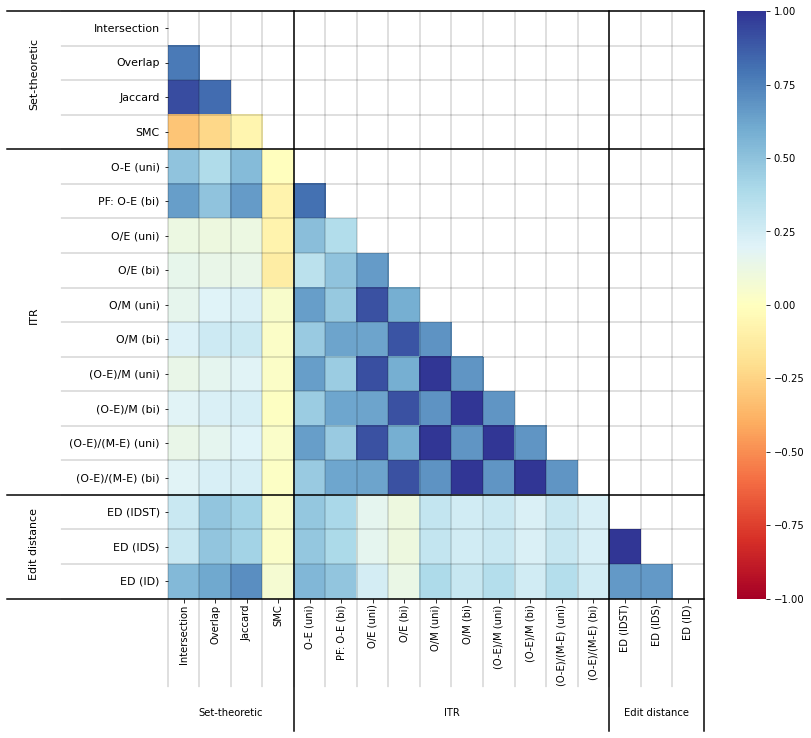

In [103]:
# and add labels to bottom
# July 28 2022
# CHECK THAT THE LABELS ON THE LEFT ARE IN THE RIGHT ORDER! (I think so because of SMT but still)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby
import datetime
import seaborn as sns

def test_table():
    months = [datetime.date(2008, i+1, 1).strftime('%B') for i in range(12)]
    seasons = ['Winter',]*3 + ['Spring',]*2 + ['Summer']*3 + ['Pre-Winter',]*4
    tuples = list(zip(months, seasons))
    index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
    d = {i: [np.random.randint(0,50) for _ in range(12)] for i in range(1950, 1960)}
    #print('d test data', d)
    #print('index', index)
    df = pd.DataFrame(d, index=index)
    #print('test df', df)
    return df

def add_line(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([ypos, ypos+ 1.2], [xpos, xpos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([ypos+.05, ypos+ 1.35], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)
    
def add_line_specialLast(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([ypos-.085, ypos+ 1.2-.085], [xpos, xpos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([ypos+.05, ypos+ 1.35], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def add_line_x(ax, xpos, ypos, level):
    #print('xpos', xpos)
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([xpos, xpos], [ypos, ypos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([xpos, xpos], [ypos, ypos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)
    
def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

# This is for y-axis
def label_group_bar_table(ax, df):
    scale = 1./df.index.size 
    #print('scale', scale)
    for level in range(df.index.nlevels):
        pos = df.index.size #index counts how many labels there are per group
        #print('pos', pos)
        for label, rpos in label_len(df.index,level):
            #print('label', label)
            #print('rpos', rpos)

            # this prints the text
            if label in ['Intersection', 'Overlap', 'Jaccard', 'SMC', 'O-E (uni)', 'PF: O-E (bi)', 'O/E (uni)', 'O/E (bi)', 'O/M (uni)', 'O/M (bi)', '(O-E)/M (uni)', '(O-E)/M (bi)', '(O-E)/(M-E) (uni)', '(O-E)/(M-E) (bi)', 'ED (IDST)', 'ED (IDS)', 'ED (ID)', 'ED (IDT)']:
                #xpos = -.2#
                xpos = -.115
                #add_line(ax, pos*scale, xpos, level)
                add_line(ax, pos*scale, xpos-0.085, level)
                pos -= rpos
                lypos = (pos + .4 * rpos)*scale    
                #lypos = (pos + .5 * rpos)*scale    
                ax.text(xpos+.1, lypos, label, ha='right', transform=ax.transAxes, fontsize=11) #rotation='vertical' here rotates all labels, incl. sub labels 
                    
            else:
                # This adjusts the position of the category labels on the left (x-axis)
                xpos = -.35 
                add_line(ax, pos*scale, xpos, level)
                # Adding something here seems to adjust the spacing/start location of the labels
                pos -= rpos
                # number changes position/start of category label text
                # I would somehow need to get the sum of all the sub-labels of that category, but I didn't and just visually adjusted it
                if label == 'ITR':
                    lypos = (pos + .5 * rpos)*scale
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')
                elif label == 'Set-theoretic':
                    lypos = (pos + .3 * rpos)*scale
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')   
                else:
                    lypos = (pos + .2 * rpos)*scale #.2
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')
        
        #add_line(ax, pos*scale , xpos, level) #this is the last solid black line
        add_line_specialLast(ax, pos*scale , xpos, level)
        xpos -= .2
        
def add_line_x(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([xpos, xpos], [ypos+.05, ypos+ 1.2], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([xpos, xpos], [ypos+.05, ypos+ 1.275], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len_x(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

# This is for x-axis labels
def label_group_bar_table_x(ax, df):
    pos = 0
    scale = 1./df.index.size #.055
    #print('scale', scale)
    for level in range(df.index.nlevels):
        # level gives me 2 levels
        #print('level', level)
        pos = df.index.size #counts how many labels there are per group
        pos = pos -17 #This needs to be adjusted depdendent on measures included
        #print('pos1', pos)

        for label, rpos in label_len_x(df.index,level):
            #print('label', label)
            #and then I need 2 different y-values for the two levels
            #different x-values for each single label
            
            #xpos = 0 #(pos + .5 * rpos)*scale
            #lypos = -2
            
            #add_line_x(ax, lypos, xpos, level)

            #lypos = (pos + .5 * rpos)*scale
            #print('lypos', lypos)
            if label in ['Intersection', 'Overlap', 'Jaccard', 'SMC', 'O-E (uni)', 'PF: O-E (bi)', 'O/E (uni)', 'O/E (bi)', 'O/M (uni)', 'O/M (bi)', '(O-E)/M (uni)', '(O-E)/M (bi)', '(O-E)/(M-E) (uni)', '(O-E)/(M-E) (bi)', 'ED (IDST)', 'ED (IDS)', 'ED (ID)', 'ED (IDT)']:
                #print('rpos', rpos)
                #print('pos2', pos)
                ypos = -.01
                #xpos = 0.025 * pos + (.025 * rpos) #(pos + .5 * rpos)*scale
                xpos = (pos + .5 * rpos)*scale
                # rpos * x = 0.025
                pos += rpos
                #print('xpos level 1', xpos)
            
            #ax.text(lypos+.1, xpos, label, ha='center', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                ax.text(xpos, ypos, label, ha='center', va='top', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                #add_line_x(ax, xpos-.5*scale , -3.6*scale, level)
                add_line_x(ax, xpos-.5*scale , ypos-(3.25*scale), level)
            else:
                print('rpos level high', rpos)
                print('pos level high', pos)
                ypos = -.2
                #xpos = 0.025 * pos + (.025 * rpos) #(pos + .5 * rpos)*scale
                xpos = (pos + .5 * rpos)*scale
                # rpos * x = 0.025
                pos += rpos
                print('xpos level 0', xpos)
            
            #ax.text(lypos+.1, xpos, label, ha='center', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                ax.text(xpos, ypos, label, ha='center', transform=ax.transAxes, rotation='horizontal') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                
                x_for_thick_line = pos * scale #so correct
                #add_line_x(ax, x_for_thick_line , ypos-.075, level) 
                add_line_x(ax, x_for_thick_line , ypos-1.275*scale, level) 
    #add_line_x(ax, 0 , -.275, 1) #manually insert y-axis bottom to add last sold think black line 

                
                
                
                
                
                
                
        
#corr = pd.read_csv('2021-04-25_Similarity_Exp2_AllWords_Clean-RelevantComparisons2.csv')
corr = pd.read_csv('2022-07-28_Similarity_Exp2_AllWords_Clean-RelevantComparisons2.csv')
#print('corr', corr)
corr = corr.drop('lcs', axis=1)
corr = corr.drop('Group', axis=1)
corr = corr.drop('editdist', axis=1).drop('mod_editdist', axis=1).drop('pairedFreq', axis=1).drop('ITR2', axis=1).drop('ARC2', axis=1).drop('editdist_IDT', axis=1)
corr = corr.rename(columns={'intersection':'Intersection', 'overlap':'Overlap', 'jaccard':'Jaccard', 'OmEuni':'O-E (uni)', 'OmEbi':'PF: O-E (bi)', 'OdEuni':'O/E (uni)', 'OdEbi':"O/E (bi)", 'OdMuni':'O/M (uni)', 'OdMbi':'O/M (bi)', 'OmEdMuni':'(O-E)/M (uni)', 'OmEdMbi':'(O-E)/M (bi)', 'OmEdMmEMuni':'(O-E)/(M-E) (uni)', 'OmEdMmEMbi':'(O-E)/(M-E) (bi)', 'editdist_IDST':'ED (IDST)', 'editdist_IDS':'ED (IDS)', 'editdist_ID':'ED (ID)'})
corrMatrix = corr.corr()
corrMatrix_y = corrMatrix.reset_index()
corrMatrix_y = corrMatrix_y.drop(corrMatrix_y.columns[0], axis=1)
#print('corrMatrix_y', corrMatrix_y)


# I think this creates an index with two categories for each tuple
idx = pd.MultiIndex.from_tuples([('Intersection','Set-theoretic'), ('Overlap','Set-theoretic'), ('Jaccard','Set-theoretic'), ('SMC','Set-theoretic'), ('O-E (uni)','ITR'), ('PF: O-E (bi)','ITR'), ('O/E (uni)','ITR'), ("O/E (bi)",'ITR'), ('O/M (uni)','ITR'), ('O/M (bi)','ITR'), ('(O-E)/M (uni)','ITR'), ('(O-E)/M (bi)','ITR'), ('(O-E)/(M-E) (uni)','ITR'), ('(O-E)/(M-E) (bi)','ITR'), ('ED (IDST)','Edit distance'), ('ED (IDS)','Edit distance'), ('ED (ID)','Edit distance')], names=['first', 'second'])  
#print('idx', idx)

# and this mask is a separate plot with the white space at on the other side; so that corrs are only shown 1x
mask = np.triu(np.ones_like(corrMatrix_y, dtype=bool))
#print('mask', mask)

# forgot what this is but I assume the list of measures?
df_corr2 = corrMatrix_y.to_dict('list')
#print('df_corr2 list', df_corr2)
df_corr3 = pd.DataFrame(df_corr2, index=idx)
#print('df_corr2 DF (3)', df_corr3)

#df = test_table()
#print('df', df)

# Finally create the figure
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
#ax2 = fig.add_subplot(111)

sns.heatmap(df_corr3, mask=mask, cmap="RdYlBu", vmin=-1, vmax=1) #
ax.set_facecolor("white") #to make the top right triangle a white mask

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_ylabel('')

# This is responsible for horizontal lines and labels on the left
label_group_bar_table(ax, df_corr3)

# I think this adjusts the row height and also vertical line length 
fig.subplots_adjust(bottom=.1*df_corr3.index.nlevels)


#plt.tight_layout()
#plt.show()

# Delete the labels on the x axis to manually add them to also show category label
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')

# This is responsible for vertical lines
label_group_bar_table_x(ax, df_corr3)

#fig.subplots_adjust(bottom=.1*df_corr3.index.nlevels)
#plt.tight_layout()
plt.savefig('Similarity_CorrMatrix_20220728', dpi='figure', bbox_inches='tight')
plt.show()